In [1]:
!pip install opencv-python seaborn tqdm


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import seaborn as sns


In [3]:
DATASET_PATH = "/home/dse/Downloads/FantasyIDiap-ICCV25-Challenge"  # Replace this with your actual full path


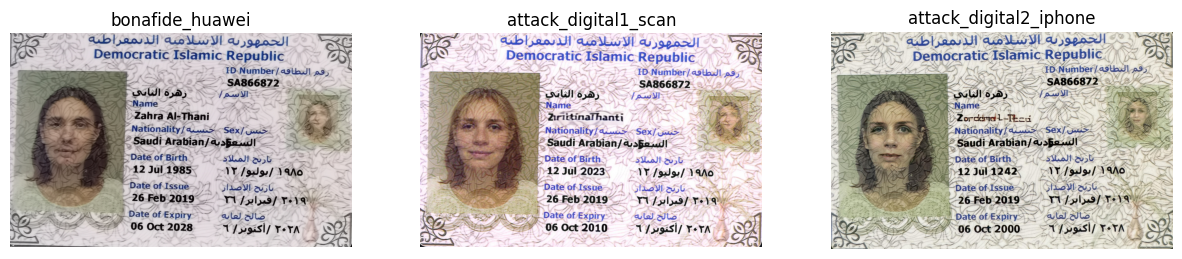

In [4]:
def load_image(path):
    img = cv2.imread(path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# Visualize samples
sample_paths = {
    "bonafide_huawei": os.path.join(DATASET_PATH, "bonafide/huawei/arabic-01_0002_000-c7338db1_1.jpg"),
    "attack_digital1_scan": os.path.join(DATASET_PATH, "attack/digital_1/scan/arabic-01_0002_000-c7338db1_1.jpg"),
    "attack_digital2_iphone": os.path.join(DATASET_PATH, "attack/digital_2/iphone15pro/arabic-01_0002_000-c7338db1_1.jpg")
}

plt.figure(figsize=(15,5))
for i, (label, path) in enumerate(sample_paths.items()):
    img = load_image(path)
    if img is not None:
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")
plt.show()


In [5]:
import pandas as pd

one_set_df = pd.read_csv(os.path.join(DATASET_PATH, "fantasyIDiap-oneset.csv"))


print("One Set Sample:")
print(one_set_df.head())




One Set Sample:
                                                path image_type  is_attack
0                  bonafide/huawei/arabic-003_03.jpg   bonafide      False
1                  bonafide/huawei/arabic-005_03.jpg   bonafide      False
2  bonafide/huawei/arabic-01_0002_000-c7338db1_1.jpg   bonafide      False
3  bonafide/huawei/arabic-01_0076_000-fd5000df_1.jpg   bonafide      False
4  bonafide/huawei/arabic-01_0095_000-18471808_1.jpg   bonafide      False


In [6]:
def build_image_dataframe(base_path):
    records = []

    # Bonafide
    for device in ['huawei', 'iphone15pro', 'scan']:
        folder = os.path.join(base_path, 'bonafide', device)
        for img_path in glob(os.path.join(folder, "*.jpg")):
            rel_path = os.path.relpath(img_path, base_path).replace("\\", "/")
            records.append({
                "path": img_path,
                "rel_path": rel_path,
                "label": "bonafide",
                "device": device,
                "attack_type": None
            })

    # Attacks
    for attack_type in ['digital_1', 'digital_2']:
        for device in ['huawei', 'iphone15pro', 'scan']:
            folder = os.path.join(base_path, 'attack', attack_type, device)
            for img_path in glob(os.path.join(folder, "*.jpg")):
                rel_path = os.path.relpath(img_path, base_path).replace("\\", "/")
                records.append({
                    "path": img_path,
                    "rel_path": rel_path,
                    "label": "attack",
                    "device": device,
                    "attack_type": attack_type
                })

    return pd.DataFrame(records)

df = build_image_dataframe(DATASET_PATH)
print("Total samples:", len(df))
df.sample(5)


Total samples: 2357


,path,rel_path,label,device,attack_type
1958,/home/dse/Downloads/FantasyIDiap-ICCV25-Challe...,attack/digital_2/iphone15pro/indian-01_0062_00...,attack,iphone15pro,digital_2
1927,/home/dse/Downloads/FantasyIDiap-ICCV25-Challe...,attack/digital_2/iphone15pro/french-NF-1095.jpg,attack,iphone15pro,digital_2
2211,/home/dse/Downloads/FantasyIDiap-ICCV25-Challe...,attack/digital_2/scan/chinese-NF-1088.jpg,attack,scan,digital_2
399,/home/dse/Downloads/FantasyIDiap-ICCV25-Challe...,bonafide/iphone15pro/french-090_03.jpg,bonafide,iphone15pro,None
515,/home/dse/Downloads/FantasyIDiap-ICCV25-Challe...,bonafide/iphone15pro/portugal-172_03.jpg,bonafide,iphone15pro,None


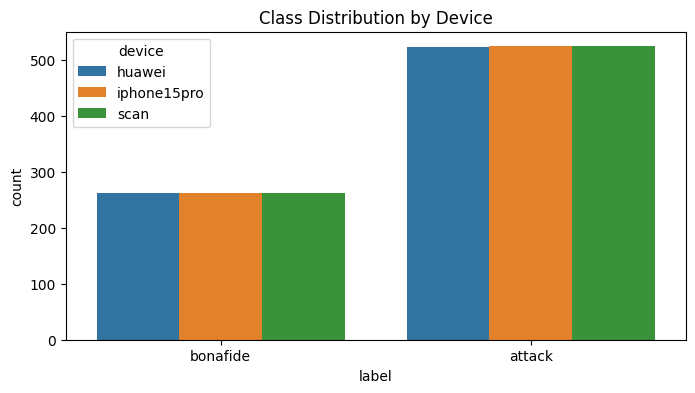

In [7]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='label', hue='device')
plt.title("Class Distribution by Device")
plt.show()


In [8]:
import os
from collections import defaultdict

def count_images_by_category(DATASET_PATH):
    
    result = defaultdict(dict)

    # Bonafide
    bonafide_path = os.path.join(DATASET_PATH, 'bonafide')
    for device in ['huawei', 'iphone15pro', 'scan']:
        device_path = os.path.join(bonafide_path, device)
        if os.path.exists(device_path):
            count = len([f for f in os.listdir(device_path) if f.endswith('.jpg')])
            result['bonafide'][device] = count
        else:
            result['bonafide'][device] = 0

    # Attacks
    attack_path = os.path.join(DATASET_PATH, 'attack')
    for attack_type in ['digital_1', 'digital_2']:
        result[attack_type] = {}
        for device in ['huawei', 'iphone15pro', 'scan']:
            device_path = os.path.join(attack_path, attack_type, device)
            if os.path.exists(device_path):
                count = len([f for f in os.listdir(device_path) if f.endswith('.jpg')])
                result[attack_type][device] = count
            else:
                result[attack_type][device] = 0

    return result

def check_ratio_integrity(image_counts):
    print("\n Device-wise Integrity Check (Expected: attacks ≈ 2x bonafide):\n")
    for device in ['huawei', 'iphone15pro', 'scan']:
        bonafide = image_counts['bonafide'].get(device, 0)
        digital_1 = image_counts['digital_1'].get(device, 0)
        digital_2 = image_counts['digital_2'].get(device, 0)
        total_attack = digital_1 + digital_2
        expected_attack = 2 * bonafide
        print(f"🔹 Device: {device}")
        print(f"   - Bonafide    : {bonafide}")
        print(f"   - Attack      : {total_attack} (Digital_1: {digital_1}, Digital_2: {digital_2})")
        print(f"   - Expected ≈  : {expected_attack}")
        print(f"   - Match     : {'Yes ' if total_attack == expected_attack else 'No '}\n")

# === Run it ===
 # replace with your actual base directory
image_counts = count_images_by_category(DATASET_PATH)

from pprint import pprint
print(" Raw Image Counts:\n")
pprint(dict(image_counts))

check_ratio_integrity(image_counts)


 Raw Image Counts:

{'bonafide': {'huawei': 262, 'iphone15pro': 262, 'scan': 262},
 'digital_1': {'huawei': 262, 'iphone15pro': 262, 'scan': 262},
 'digital_2': {'huawei': 261, 'iphone15pro': 262, 'scan': 262}}

 Device-wise Integrity Check (Expected: attacks ≈ 2x bonafide):

🔹 Device: huawei
   - Bonafide    : 262
   - Attack      : 523 (Digital_1: 262, Digital_2: 261)
   - Expected ≈  : 524
   - Match     : No 

🔹 Device: iphone15pro
   - Bonafide    : 262
   - Attack      : 524 (Digital_1: 262, Digital_2: 262)
   - Expected ≈  : 524
   - Match     : Yes 

🔹 Device: scan
   - Bonafide    : 262
   - Attack      : 524 (Digital_1: 262, Digital_2: 262)
   - Expected ≈  : 524
   - Match     : Yes 



In [9]:
import os

def get_filenames(folder):
    return set([f for f in os.listdir(folder) if f.endswith('.jpg')])

# Base paths
bonafide_path = '/home/dse/Downloads/FantasyIDiap-ICCV25-Challenge/bonafide/huawei'
digital1_path = '/home/dse/Downloads/FantasyIDiap-ICCV25-Challenge/attack/digital_1/huawei'
digital2_path = '/home/dse/Downloads/FantasyIDiap-ICCV25-Challenge/attack/digital_2/huawei'

# Load filenames
bonafide_files = get_filenames(bonafide_path)
digital1_files = get_filenames(digital1_path)
digital2_files = get_filenames(digital2_path)

# Find missing or mismatched files
expected_attack_files = bonafide_files  # Assuming names are same or based on bonafide
missing_in_digital2 = expected_attack_files - digital2_files
extra_in_digital2 = digital2_files - expected_attack_files

print(f"\n Files in bonafide but NOT in digital_2 (missing): {missing_in_digital2}")
print(f" Extra files in digital_2 not in bonafide (possibly misnamed): {extra_in_digital2}")



 Files in bonafide but NOT in digital_2 (missing): {'french-01_0006_000-f9f1aca7_0.jpg'}
 Extra files in digital_2 not in bonafide (possibly misnamed): set()


In [10]:
# 3. Load split CSVs
train_df = pd.read_csv('/home/dse/Downloads/FantasyIDiap-ICCV25-Challenge/fantasyIDiap-train.csv')
test_df = pd.read_csv('/home/dse/Downloads/FantasyIDiap-ICCV25-Challenge/fantasyIDiap-test.csv')

# 4. Extract paths from CSVs
train_files = set(train_df['path'].str.replace("\\", "/"))
test_files = set(test_df['path'].str.replace("\\", "/"))


🔍 Total Samples
Train: 1899 | Test: 459

 is_attack Distribution
Train:
 is_attack
True     1266
False     633
Name: count, dtype: int64 

Test:
 is_attack
True     306
False    153
Name: count, dtype: int64 

img_type Distribution
Train:
 image_type
bonafide     633
digital_2    633
digital_1    633
Name: count, dtype: int64 

Test:
 image_type
bonafide     153
digital_2    153
digital_1    153
Name: count, dtype: int64 

Combined Distribution (img_type vs is_attack)
Train:
 is_attack   False  True 
image_type              
bonafide      633      0
digital_1       0    633
digital_2       0    633 

Test:
 is_attack   False  True 
image_type              
bonafide      153      0
digital_1       0    153
digital_2       0    153 



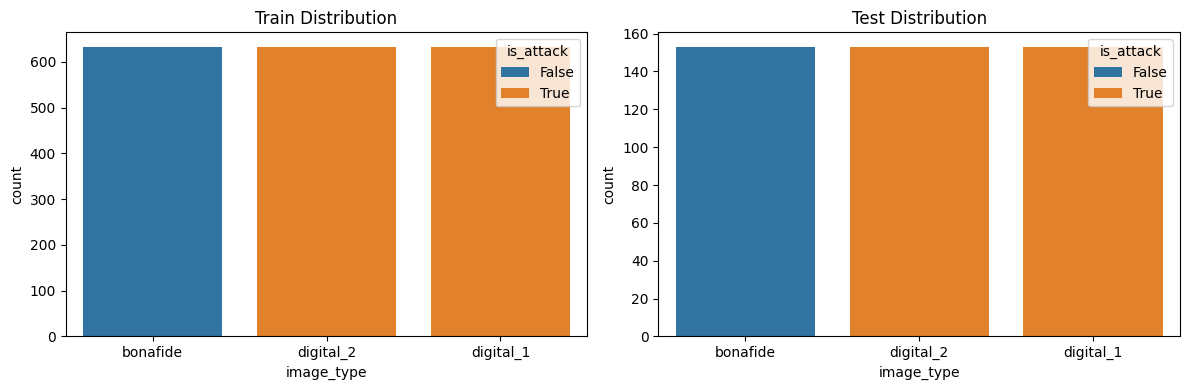

In [11]:
print("🔍 Total Samples")
print(f"Train: {len(train_df)} | Test: {len(test_df)}\n")

# Distribution by 'is_attack'
print(" is_attack Distribution")
print("Train:\n", train_df['is_attack'].value_counts(), "\n")
print("Test:\n", test_df['is_attack'].value_counts(), "\n")

# Distribution by 'img_type'
print("img_type Distribution")
print("Train:\n", train_df['image_type'].value_counts(), "\n")
print("Test:\n", test_df['image_type'].value_counts(), "\n")

# Cross-tab: Combined distribution
print("Combined Distribution (img_type vs is_attack)")
print("Train:\n", pd.crosstab(train_df['image_type'], train_df['is_attack']), "\n")
print("Test:\n", pd.crosstab(test_df['image_type'], test_df['is_attack']), "\n")

# Optional: Visual check
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.countplot(data=train_df, x='image_type', hue='is_attack')
plt.title("Train Distribution")

plt.subplot(1, 2, 2)
sns.countplot(data=test_df, x='image_type', hue='is_attack')
plt.title("Test Distribution")

plt.tight_layout()
plt.show()

In [12]:

# 5. Assign split
def get_split(row):
    rel_path = row['rel_path']
    if rel_path in train_files:
        return 'train'
    elif rel_path in test_files:
        return 'test'
    else:
        return 'val'  # Hold-out or extra

df['split'] = df.apply(get_split, axis=1)

In [13]:
df.head()

,path,rel_path,label,device,attack_type,split
0,/home/dse/Downloads/FantasyIDiap-ICCV25-Challe...,bonafide/huawei/portugal-125_03.jpg,bonafide,huawei,None,train
1,/home/dse/Downloads/FantasyIDiap-ICCV25-Challe...,bonafide/huawei/portugal-NM-1102.jpg,bonafide,huawei,None,train
2,/home/dse/Downloads/FantasyIDiap-ICCV25-Challe...,bonafide/huawei/chinese-142_03.jpg,bonafide,huawei,None,train
3,/home/dse/Downloads/FantasyIDiap-ICCV25-Challe...,bonafide/huawei/russian-NF-1081.jpg,bonafide,huawei,None,train
4,/home/dse/Downloads/FantasyIDiap-ICCV25-Challe...,bonafide/huawei/russian-132_03.jpg,bonafide,huawei,None,train


In [14]:
# Count number of samples assigned to validation set
val_count = (df['split'] == 'val').sum()
print(f"Number of 'val' samples in split column: {val_count}")


Number of 'val' samples in split column: 0


In [15]:
df.columns.tolist()

['path', 'rel_path', 'label', 'device', 'attack_type', 'split']

In [16]:
print("🔍 Unique value counts for each column:\n")
for col in df.columns:
    print(f"Column: {col}")
    print(df[col].value_counts(dropna=False))
    print("-" * 50)


🔍 Unique value counts for each column:

Column: path
path
/home/dse/Downloads/FantasyIDiap-ICCV25-Challenge/attack/digital_2/scan/ukraine-NM-1007.jpg             1
/home/dse/Downloads/FantasyIDiap-ICCV25-Challenge/bonafide/huawei/portugal-125_03.jpg                   1
/home/dse/Downloads/FantasyIDiap-ICCV25-Challenge/bonafide/huawei/portugal-NM-1102.jpg                  1
/home/dse/Downloads/FantasyIDiap-ICCV25-Challenge/bonafide/huawei/chinese-142_03.jpg                    1
/home/dse/Downloads/FantasyIDiap-ICCV25-Challenge/bonafide/huawei/russian-NF-1081.jpg                   1
                                                                                                       ..
/home/dse/Downloads/FantasyIDiap-ICCV25-Challenge/bonafide/huawei/indian-012_03.jpg                     1
/home/dse/Downloads/FantasyIDiap-ICCV25-Challenge/bonafide/huawei/french-033_03.jpg                     1
/home/dse/Downloads/FantasyIDiap-ICCV25-Challenge/bonafide/huawei/russian-027_03.jpg          

In [17]:
print(df['split'].value_counts())


split
train    1899
test      458
Name: count, dtype: int64


In [18]:


# Basic Info
print("Total Samples:", len(df))
print("\nColumns:", df.columns.tolist())

# Check for Nulls
print("\nMissing Values:")
print(df.isnull().sum())

# Check if image paths exist
df['path_exists'] = df['path'].apply(os.path.exists)
missing_files = df[~df['path_exists']]
print(f"\nMissing image paths: {len(missing_files)}")

# Split Distribution
print("\nSplit distribution:")
print(df['split'].value_counts())

# Class Distribution in Each Split
for split in ['train', 'test', 'val']:
    print(f"\nSplit: {split.upper()}")
    subset = df[df['split'] == split]
    print(subset['label'].value_counts())
    print("\nAttack type distribution:")
    print(subset['attack_type'].value_counts())



Total Samples: 2357

Columns: ['path', 'rel_path', 'label', 'device', 'attack_type', 'split']

Missing Values:
path             0
rel_path         0
label            0
device           0
attack_type    786
split            0
dtype: int64

Missing image paths: 0

Split distribution:
split
train    1899
test      458
Name: count, dtype: int64

Split: TRAIN
label
attack      1266
bonafide     633
Name: count, dtype: int64

Attack type distribution:
attack_type
digital_1    633
digital_2    633
Name: count, dtype: int64

Split: TEST
label
attack      305
bonafide    153
Name: count, dtype: int64

Attack type distribution:
attack_type
digital_1    153
digital_2    152
Name: count, dtype: int64

Split: VAL
Series([], Name: count, dtype: int64)

Attack type distribution:
Series([], Name: count, dtype: int64)


In [19]:
import os
from PIL import Image
import pandas as pd

# Let's say your DataFrame is named df and contains 'path' column
# Sample a few images from your dataset
sample_paths = df['path'].sample(5, random_state=42).tolist()

for path in sample_paths:
    with Image.open(path) as img:
        print(f"{os.path.basename(path)} - Size: {img.size}, Mode: {img.mode}")


portugal-066_03.jpg - Size: (3225, 2001), Mode: RGB
turkiye-083_03.jpg - Size: (2831, 1791), Mode: RGB
portugal-017_03.jpg - Size: (3209, 1979), Mode: RGB
portugal-143_03.jpg - Size: (1995, 1247), Mode: RGB
usa-009_03.jpg - Size: (3204, 1979), Mode: RGB


In [20]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


In [21]:
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())


2.7.1+cu118
CUDA available: False


/home/dse/jupyter_env/lib/python3.12/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [22]:
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
from PIL import Image
import torch
import os


class FantasyIDDataset(Dataset):
    def __init__(self, dataframe, split='train', image_size=(224, 224)):
        self.df = dataframe[dataframe['split'] == split].reset_index(drop=True)
        self.split = split
        self.image_size = image_size
        
        # Label encoding: attack = 1, bonafide = 0
        self.label_map = {'bonafide': 0, 'attack': 1}

        # Transforms
        if self.split == 'train':
            self.transform = transforms.Compose([
                transforms.Resize(self.image_size),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.3, saturation=0.2)], p=0.7),
                transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(self.image_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
            ])

    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
     try:
        row = self.df.iloc[idx]
        img_path = row['path']
        label_str = row['label']

        if label_str not in self.label_map:
            raise ValueError(f"Unknown label: {label_str} at index {idx}")

        label = self.label_map[label_str]

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        metadata = {
            "rel_path": row.get('rel_path', ''),
            "device": row.get('device', ''),
            "attack_type": row.get('attack_type', ''),
            "split": row.get('split', '')
        }

        return image, label, metadata

     except Exception as e:
        print(f"[ERROR @ idx {idx}] path: {img_path} | label: {row.get('label')} | error: {e}")
        return None




In [23]:
# Split data
train_dataframe = df[df["split"] == "train"].reset_index(drop=True)
test_dataframe = df[df["split"] == "test"].reset_index(drop=True)

if test_dataframe.empty:
    print("Warning: test_df is empty. Falling back to 'val' as test set.")
    test_dataframe = df[df["split"] == "val"].reset_index(drop=True)

# WeightedRandomSamplerr this manages class (categories bonafide and attack in this case) imbalances by sampling thec data randomly by assigning
#lower weight to the dominant class and higher to minority here in this case the bonafide images are lesser than that of attack.

label_encoder = LabelEncoder()
train_dataframe['label_encoded'] = label_encoder.fit_transform(train_dataframe['label']) #encoding bonafide -> 0 , attack->1

class_sample_count = train_dataframe['label_encoded'].value_counts().sort_index().tolist()
weights = 1. / torch.tensor(class_sample_count, dtype=torch.float)
samples_weight = train_dataframe['label_encoded'].map(lambda x: float(weights[x])).astype(float).values
samples_weight = torch.tensor(samples_weight, dtype=torch.float)


sampler = WeightedRandomSampler(weights=samples_weight, num_samples=len(samples_weight), replacement=True)

# Instantiate datasets (wrapper classes)
train_dataset = FantasyIDDataset(train_dataframe, split='train')
test_dataset = FantasyIDDataset(test_dataframe, split='test')

print(f" train_dataset size: {len(train_dataset)}")
print(f"test_dataset size: {len(test_dataset)}")

#dataloader : wrapper around the dataset that divides data into batches , shuffules the data for each epoch.

def custom_collate(batch):
    # Remove all None samples
    batch = [x for x in batch if x is not None]

    # If the whole batch was bad, return empty
    if len(batch) == 0:
        return None

    # Unzip and collate parts
    images, labels, metadata = zip(*batch)
    return (
        torch.utils.data.default_collate(images),
        torch.utils.data.default_collate(labels),
        list(metadata)
    )



train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler,collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,collate_fn=custom_collate)

 train_dataset size: 1899
test_dataset size: 458


In [24]:
# Inspect one sample
img, label, metadata = train_dataset[0]

print("Image Tensor Shape:", img.shape)
print("Label:", label)
print("Metadata:", metadata)

Image Tensor Shape: torch.Size([3, 224, 224])
Label: 0
Metadata: {'rel_path': 'bonafide/huawei/portugal-125_03.jpg', 'device': 'huawei', 'attack_type': None, 'split': 'train'}


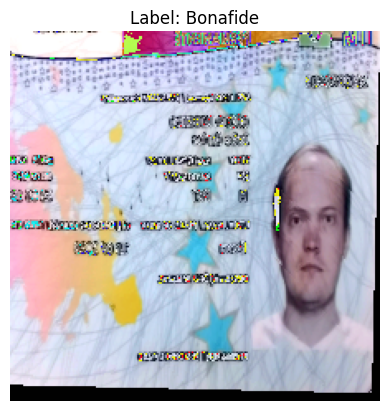

In [25]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

plt.imshow(TF.to_pil_image(img)) #Converts tensor (a multi-dimensional array) back to image.
plt.title(f"Label: {'Bonafide' if label==0 else 'Attack'}")
plt.axis('off')
plt.show()


In [26]:
import torchvision


In [27]:
df['path'].apply(os.path.exists).value_counts()

path
True    2357
Name: count, dtype: int64

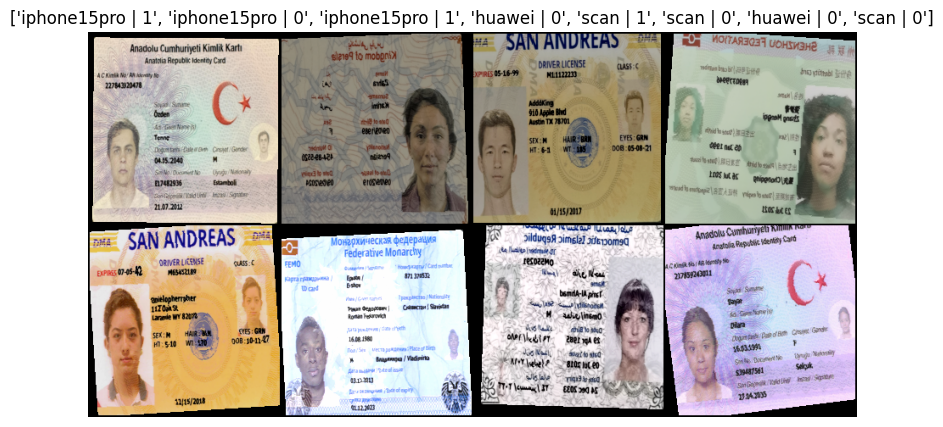

In [28]:


def visualize_batch(loader):
    images, labels, metadata = next(iter(loader))
    grid_img = torchvision.utils.make_grid(images[:8], nrow=4, normalize=True)
    plt.figure(figsize=(10,5))
    plt.imshow(grid_img.permute(1, 2, 0)) #Convert from [C,H,W] (channels(3 for RGB),Height,Weight) used by pytorch  to [H,W,C] which ids the std visualization.
    #format for matplotlib
    plt.title(
    [f"{metadata[i]['device']} | {labels[i].item()}" for i in range(8)]
    )
    plt.axis('off')
    plt.show()

visualize_batch(train_loader)


In [29]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image


In [30]:
import random
import numpy as np
import torch

#defining a fixed starting point for the model so that it becomes reoroducible and we get same results everytime we re-run the code.
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [31]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights

def get_model_and_optimizer(load_weights_path=None):
    weights = ResNet18_Weights.DEFAULT
    model = resnet18(weights=weights)
    model.fc = nn.Sequential(
        nn.Dropout(p=0.4),
        nn.Linear(model.fc.in_features, 2)  # Binary classification: Real vs Fake
    )
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    if load_weights_path and os.path.exists(load_weights_path):
        model.load_state_dict(torch.load(load_weights_path, map_location=device))
        model.eval()
    
    # Class weights: [bonafide, spoof]
    class_weights = torch.tensor([1.0, 1266 / 633], device=device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    return model, criterion, optimizer, device


In [32]:

model, criterion, optimizer, device = get_model_and_optimizer()


In [33]:
import os
import pandas as pd
import torch

# === Utility Setup ===
results_matrix = []
os.makedirs("saved_models", exist_ok=True)

def save_model(model, combo_name):
    torch.save(model.state_dict(), f"saved_models/{combo_name}.ptl")

def record_result(combo_name, test_device, test_attack, acc, avg_loss):
    results_matrix.append({
        "Train_Combo": combo_name,
        "Test_Combo": f"{test_device}_{test_attack}",
        "Accuracy": round(acc, 4),
        "Loss": round(avg_loss, 4)
    })
def save_results_to_csv():
    results_df = pd.DataFrame(results_matrix)
    results_df.to_csv("all_results_detailed.csv", index=False)

    try:
        acc_matrix = df.pivot(index="Train_Combo", columns="Test_Combo", values="Accuracy")
        acc_matrix.to_csv("accuracy_matrix.csv")
        print("[INFO] accuracy_matrix.csv saved.")
    except KeyError as e:
        print(f"[ERROR] Pivot failed: missing column {e}. Columns present: {df.columns.tolist()}")

In [34]:
"""import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from tqdm import tqdm

# Dataset class (original version)
from torch.utils.data import Dataset

class FantasyIDDataset(Dataset):
    def __init__(self, dataframe, split='train', image_size=(224, 224)):
        self.df = dataframe[dataframe['split'] == split].reset_index(drop=True)
        self.split = split
        self.image_size = image_size
        self.label_map = {'bonafide': 0, 'attack': 1}

        if self.split == 'train':
            self.transform = transforms.Compose([
                transforms.Resize(self.image_size),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply([
                    transforms.ColorJitter(brightness=0.4, contrast=0.3, saturation=0.2)
                ], p=0.7),
                transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(self.image_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
            ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            row = self.df.iloc[idx]
            img_path = row['path']
            label_str = row['label']

            if label_str not in self.label_map:
                raise ValueError(f"Unknown label: {label_str} at index {idx}")

            label = self.label_map[label_str]
            image = Image.open(img_path).convert("RGB")
            image = self.transform(image)

            metadata = {
                "rel_path": row.get('rel_path', ''),
                "device": row.get('device', ''),
                "attack_type": row.get('attack_type', ''),
                "split": row.get('split', '')
            }
            return image, label, metadata

        except Exception as e:
            print(f"[ERROR @ idx {idx}] error: {e}")
            return None


def custom_collate(batch):
    batch = [x for x in batch if x is not None]
    if len(batch) == 0:
        return None
    images, labels, metadata = zip(*batch)
    return (
        torch.utils.data.default_collate(images),
        torch.utils.data.default_collate(labels),
        list(metadata)
    )


# Assume df is already available in memory
df["label"] = df["label"].str.strip().str.lower()
df = df[df["label"].isin(["bonafide", "attack"])]
df = df.dropna(subset=["path"]).reset_index(drop=True)

# Setup label encoder
label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["label"])

# Model
class ResNet18Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = resnet18(weights=ResNet18_Weights.DEFAULT)
        in_features = backbone.fc.in_features
        backbone.fc = nn.Linear(in_features, 2)
        self.backbone = backbone

    def forward(self, x):
        return self.backbone(x)


# Training Function
def train_model(train_df, save_path, unfreeze_after=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ResNet18Classifier().to(device)

    # Freeze backbone initially
    for param in model.backbone.parameters():
        param.requires_grad = False
    for param in model.backbone.fc.parameters():
        param.requires_grad = True

    # Balance the classes
    class_counts = train_df["label_encoded"].value_counts().sort_index().tolist()
    weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    samples_weight = train_df["label_encoded"].map(lambda x: float(weights[x])).astype(float).values
    samples_weight = torch.tensor(samples_weight, dtype=torch.float)
    sampler = WeightedRandomSampler(weights=samples_weight, num_samples=len(samples_weight), replacement=True)

    dataset = FantasyIDDataset(train_df, split='train')
    loader = DataLoader(dataset, batch_size=32, sampler=sampler, collate_fn=custom_collate)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(10):
        if epoch == unfreeze_after:
            print("\n🔓 Unfreezing all layers after epoch", epoch)
            for param in model.backbone.parameters():
                param.requires_grad = True

        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for batch in tqdm(loader, desc=f"[Epoch {epoch+1}]"):
            if batch is None:
                continue
            images, labels, _ = batch
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        print(f"Epoch {epoch+1}: Loss={running_loss/total:.4f}, Acc={correct/total:.4f}")

    model.eval()
    scripted_model = torch.jit.script(model.cpu())
    torch.jit.save(scripted_model, save_path)
    print(f"✅ Model saved to {save_path}")


# Train on training split only
train_df = df[df["split"] == "train"].copy()
train_model(train_df, "weights/resnet18_all_devices_all_attacks_trainsplit.pt")"""




'import os\nimport torch\nimport torch.nn as nn\nimport torch.optim as optim\nfrom torch.utils.data import DataLoader, WeightedRandomSampler\nfrom torchvision.models import resnet18, ResNet18_Weights\nfrom torchvision import transforms\nfrom PIL import Image\nfrom sklearn.preprocessing import LabelEncoder\nimport pandas as pd\nfrom tqdm import tqdm\n\n# Dataset class (original version)\nfrom torch.utils.data import Dataset\n\nclass FantasyIDDataset(Dataset):\n    def __init__(self, dataframe, split=\'train\', image_size=(224, 224)):\n        self.df = dataframe[dataframe[\'split\'] == split].reset_index(drop=True)\n        self.split = split\n        self.image_size = image_size\n        self.label_map = {\'bonafide\': 0, \'attack\': 1}\n\n        if self.split == \'train\':\n            self.transform = transforms.Compose([\n                transforms.Resize(self.image_size),\n                transforms.RandomHorizontalFlip(p=0.5),\n                transforms.RandomApply([\n          

In [35]:
# Full Dataset Training (ignore 'split' column)
"""class FullDataset(FantasyIDDataset):
    def __init__(self, dataframe, image_size=(224, 224)):
        self.df = dataframe.reset_index(drop=True)
        self.split = 'train'  # Apply train-time augmentations
        self.image_size = image_size
        self.label_map = {'bonafide': 0, 'attack': 1}

        self.transform = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([
                transforms.ColorJitter(brightness=0.4, contrast=0.3, saturation=0.2)
            ], p=0.7),
            transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])

# Training Function for Full Dataset
def train_model_full(train_df, save_path, unfreeze_after=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ResNet18Classifier().to(device)

    # Freeze backbone initially
    for param in model.backbone.parameters():
        param.requires_grad = False
    for param in model.backbone.fc.parameters():
        param.requires_grad = True

    # Balance the classes
    class_counts = train_df["label_encoded"].value_counts().sort_index().tolist()
    weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    samples_weight = train_df["label_encoded"].map(lambda x: float(weights[x])).astype(float).values
    samples_weight = torch.tensor(samples_weight, dtype=torch.float)
    sampler = WeightedRandomSampler(weights=samples_weight, num_samples=len(samples_weight), replacement=True)

    dataset = FullDataset(train_df)
    loader = DataLoader(dataset, batch_size=32, sampler=sampler, collate_fn=custom_collate)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(10):
        if epoch == unfreeze_after:
            print("\n🔓 Unfreezing all layers after epoch", epoch)
            for param in model.backbone.parameters():
                param.requires_grad = True

        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for batch in tqdm(loader, desc=f"[Epoch {epoch+1}]"):
            if batch is None:
                continue
            images, labels, _ = batch
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        print(f"Epoch {epoch+1}: Loss={running_loss/total:.4f}, Acc={correct/total:.4f}")

    model.eval()
    scripted_model = torch.jit.script(model.cpu())
    torch.jit.save(scripted_model, save_path)
    print(f"✅ Model saved to {save_path}")

# Run full dataset training
train_model_full(df, "weights/resnet18_all_devices_all_attacks_full.pt")"""


'class FullDataset(FantasyIDDataset):\n    def __init__(self, dataframe, image_size=(224, 224)):\n        self.df = dataframe.reset_index(drop=True)\n        self.split = \'train\'  # Apply train-time augmentations\n        self.image_size = image_size\n        self.label_map = {\'bonafide\': 0, \'attack\': 1}\n\n        self.transform = transforms.Compose([\n            transforms.Resize(self.image_size),\n            transforms.RandomHorizontalFlip(p=0.5),\n            transforms.RandomApply([\n                transforms.ColorJitter(brightness=0.4, contrast=0.3, saturation=0.2)\n            ], p=0.7),\n            transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),\n            transforms.ToTensor(),\n            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)\n        ])\n\n# Training Function for Full Dataset\ndef train_model_full(train_df, save_path, unfreeze_after=4):\n    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n    mode

In [36]:
import torch
from torchvision.models import resnet18
import torch.nn as nn
from torchvision.models import ResNet18_Weights

# Load your trained model
model_path = "weights/resnet18_all_devices_all_attacks_trainsplit.pt"
model = torch.jit.load(model_path)
model.eval()

# Create dummy input for tracing
dummy_input = torch.randn(1, 3, 224, 224)

# Trace the model
traced_model = torch.jit.trace(model, dummy_input)

# Save as flat .pt file
torch.jit.save(traced_model, "weights/resnet18_all_devices_all_attacks_trainsplit_traced.pt")


/home/dse/jupyter_env/lib/python3.12/site-packages/torch/jit/_trace.py:685: UserWarning: The input to trace is already a ScriptModule, tracing it is a no-op. Returning the object as is.
  warnings.warn(


In [37]:
model_path = "weights/resnet18_all_devices_all_attacks_full.pt"
model = torch.jit.load(model_path)
model.eval()

dummy_input = torch.randn(1, 3, 224, 224)

traced_model = torch.jit.trace(model, dummy_input)

torch.jit.save(traced_model, "weights/resnet18_all_devices_all_attacks_full_traced.pt")


In [38]:
import importlib.metadata
import subprocess
import re

# List of packages used in the project
packages = [
    "fastapi",
    "python-multipart",
    "numpy",
    "pillow",
    "torch",
    "torchvision",
    "timm",
    "pandas",
    "scikit-learn",
    "tqdm"
]

print(f"{'Package':<20} {'Installed':<15} {'Latest (pypi.org)':<20}")
print("-" * 60)

for package in packages:
    try:
        # Get installed version
        installed = importlib.metadata.version(package)
    except importlib.metadata.PackageNotFoundError:
        installed = "Not Installed"

    try:
        # Get latest version using pip index
        result = subprocess.run(
            ["pip", "index", "versions", package],
            stdout=subprocess.PIPE,
            stderr=subprocess.DEVNULL,
            text=True
        )
        match = re.search(r"Available versions: ([\d.,\s]+)", result.stdout)
        if match:
            latest = match.group(1).split(",")[0].strip()
        else:
            latest = "Not Found"
    except Exception as e:
        latest = "Error"

    print(f"{package:<20} {installed:<15} {latest:<20}")







Package              Installed       Latest (pypi.org)   
------------------------------------------------------------
fastapi              Not Installed   0.116.1             
python-multipart     Not Installed   0.0.20              
numpy                2.2.6           2.3.1               
pillow               11.2.1          11.3.0              
torch                2.7.1+cu118     2.7.1               
torchvision          0.22.1+cu118    0.22.1              
timm                 1.0.16          1.0.17              
pandas               2.2.3           2.3.1               
scikit-learn         1.6.1           1.7.0               
tqdm                 4.67.1          4.67.1              


In [39]:
"""import torch.optim as optim
from tqdm import tqdm #visualises training progress with progress bars
import time

def train_model(model, train_loader, test_loader, criterion, optimizer, device, epochs=10, patience=3):
    model.to(device) #moved model to GPU.in pytorch tensors and models must be in same device

    best_loss = float('inf')
    epochs_no_improve = 0
    unfreeze_epoch = 4

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    start_time = time.time()

    for epoch in range(epochs):
        if epoch == unfreeze_epoch:
            for param in model.parameters():
                param.requires_grad = True #This line unfreezes all model parameters(weightd and biases), allowing them to be updated during backpropagation. 
            print(f" Unfroze model backbone at epoch {epoch}") #This technique is called fine-tuning 
            # we first train only the custom layers (e.g., classifier head), and then gradually fine-tune the backbone network.

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        print(f"\nEpoch [{epoch+1}/{epochs}]")
        for images, labels, _ in tqdm(train_loader, desc="Training", leave=False):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad() #Clears the gradients of all model parameters before the current batch’s backward pass. 
            #Necessary to avoid gradient accumulation across batches.
            outputs = model(images)
            loss = criterion(outputs, labels) #Computes the loss between
            #model predictions and true labels using the previously defined loss function (CrossEntropyLoss).
            loss.backward() #back-propogation
            optimizer.step() #Updates model weights using the computed gradients. Implements one optimization step (Adam optimizer).

            running_loss += loss.item() * images.size(0) #.item() converts tensor to py float,loss = criterion(outputs, labels)
            #is the average loss per sample in the batch.So multiplying it by the batch size gives 
            #the total (cumulative) loss for this batch.
            _, predicted = torch.max(outputs, 1) #This gives us the predicted class label (as an integer like 0 or 1) for every image in the batch.
            total += labels.size(0) #Adds the number of samples in the current batch to the overall counter total.
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / total #Divides total loss (accumulated across all batches) by the total number of samples seen.
        train_accuracy = correct / total #Divides the number of correctly predicted samples by the total number of samples.
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluate on test set
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():#Disables gradient computation during evaluation to save memory and improve speed.
            for images, labels, _ in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss /= total
        test_accuracy = correct / total
        test_losses.append(test_loss) #Appends the computed average loss and accuracy of the current epoch to a list.
        test_accuracies.append(test_accuracy)

        print(f" Epoch {epoch+1} Summary:")
        print(f"   Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy*100:.2f}%")
        print(f"   Test  Loss: {test_loss:.4f}, Test  Acc: {test_accuracy*100:.2f}%")

        # Early stopping check
        if test_loss < best_loss:
            best_loss = test_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(" Early stopping triggered!")
                break

    total_time = (time.time() - start_time) / 60
    print(f"\n Training completed in {total_time:.2f} minutes")
    return model, train_losses, test_losses, train_accuracies, test_accuracies"""



'import torch.optim as optim\nfrom tqdm import tqdm #visualises training progress with progress bars\nimport time\n\ndef train_model(model, train_loader, test_loader, criterion, optimizer, device, epochs=10, patience=3):\n    model.to(device) #moved model to GPU.in pytorch tensors and models must be in same device\n\n    best_loss = float(\'inf\')\n    epochs_no_improve = 0\n    unfreeze_epoch = 4\n\n    train_losses, test_losses = [], []\n    train_accuracies, test_accuracies = [], []\n\n    start_time = time.time()\n\n    for epoch in range(epochs):\n        if epoch == unfreeze_epoch:\n            for param in model.parameters():\n                param.requires_grad = True #This line unfreezes all model parameters(weightd and biases), allowing them to be updated during backpropagation. \n            print(f" Unfroze model backbone at epoch {epoch}") #This technique is called fine-tuning \n            # we first train only the custom layers (e.g., classifier head), and then gradually

In [40]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels, _ in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            # Predictions: take the class with max probability
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / total if total > 0 else 0
    accuracy = correct / total if total > 0 else 0

    return accuracy, avg_loss

In [41]:
def get_predictions(model, dataloader, device):
    model.eval()
    all_preds, all_labels, all_metadata = [], [], [] #all_preds: model’s predicted class labels.all_labels: true labels from the dataset.
    with torch.no_grad():
        for images, labels, metadata in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
            all_metadata.extend(metadata)
    return np.array(all_preds), np.array(all_labels), all_metadata


In [42]:
def custom_collate(batch):
    # Remove all None samples
    batch = [x for x in batch if x is not None]

    # If the whole batch was bad, return empty
    if len(batch) == 0:
        return None

    # Unzip and collate parts
    images, labels, metadata = zip(*batch)
    return (
        torch.utils.data.default_collate(images),
        torch.utils.data.default_collate(labels),
        list(metadata)
    )


In [43]:
"""import time
from tqdm import tqdm
from itertools import product
from sklearn.metrics import classification_report, confusion_matrix
from torchvision.models import resnet18, ResNet18_Weights

devices = ["huawei", "scan", "iphone15pro"]
attacks = ["digital_1", "digital_2"]

for device, attack in product(devices, attacks):
    combo_name = f"{device}_bonafide+{device}_{attack}"
    print(f"\n[INFO] Training on: {combo_name}")

    attack_mask = (
        (df["split"] == "train") &
        (df["device"] == device) &
        (df["attack_type"] == attack) &
        (df["label"] == "attack")
    )
    bonafide_mask = (
        (df["split"] == "train") &
        (df["device"] == device) &
        (df["label"] == "bonafide")
    )

    train_df = df[attack_mask | bonafide_mask].reset_index(drop=True)

    if train_df.empty or train_df["label"].nunique() < 2:
        print(f"[WARNING] Skipping training on {combo_name} — not enough class diversity")
        continue

    print(f"[DEBUG] Training samples: {train_df['label'].value_counts().to_dict()}")

    train_df["label_encoded"] = label_encoder.transform(train_df["label"])
    class_counts = train_df["label_encoded"].value_counts().to_dict()
    total = sum(class_counts.values())
    class_weights = {cls: total / count for cls, count in class_counts.items()}
    sample_weights = train_df["label_encoded"].map(class_weights).values

    train_dataset = FantasyIDDataset(train_df, split='train')
    sampler = WeightedRandomSampler(
        weights=torch.tensor(sample_weights, dtype=torch.float),
        num_samples=len(sample_weights),
        replacement=True
    )
    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, collate_fn=custom_collate)

    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = torch.nn.Linear(model.fc.in_features, 2)
    torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(torch_device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()

    start_time = time.time()
    model.train()
    epochs = 10
    for epoch in range(epochs):
        running_loss = 0.0
        correct, total = 0, 0
        loop = tqdm(train_loader, desc=f"[{combo_name}] Epoch {epoch+1}/{epochs}", leave=False)
        for batch in loop:
            if batch is None or batch[0].nelement() == 0:
                continue
            if batch is None:
                continue
            images, labels, _ = batch
            images, labels = images.to(torch_device), labels.to(torch_device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=running_loss / (total or 1), acc=correct / (total or 1))

        print(f"[EPOCH {epoch+1}] Loss: {running_loss/total:.4f} | Acc: {correct/total:.4f}")
    end_time = time.time()
    print(f"[DONE] Training completed in {(end_time - start_time)/60:.2f} minutes")
    save_model(model, combo_name)

    # === Evaluation on 6 test sets ===
    for test_device, test_attack in product(devices, attacks):
        test_mask = (
            (df["split"] == "test") &
            (df["device"] == test_device) &
            (
                (df["attack_type"] == test_attack) |
                (df["label"] == "bonafide")
            )
        )
        test_df = df[test_mask].reset_index(drop=True)
        if test_df.empty or test_df["label"].nunique() < 2:
            print(f"[SKIP] Test on {test_device}_{test_attack} — not enough data")
            continue

        test_df["label_encoded"] = label_encoder.transform(test_df["label"])
        test_dataset = FantasyIDDataset(test_df, split='test')
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate)

        model.eval()
        test_loss, correct, total = 0.0, 0, 0
        y_true, y_pred = [], []

        with torch.no_grad():
            for batch in tqdm(test_loader, desc=f"[Eval {test_device}_{test_attack}]", leave=False):
                if batch is None or batch[0].nelement() == 0:
                    continue
                if batch is None:
                    continue
                images, labels, _ = batch
                images, labels = images.to(torch_device), labels.to(torch_device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = outputs.max(1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        acc = correct / total
        avg_loss = test_loss / total
        print(f"[RESULT] Trained on {combo_name} → Tested on {test_device}_{test_attack} | Acc: {acc:.4f}, Loss: {avg_loss:.4f}")
        print("Confusion Matrix:")
        print(confusion_matrix(y_true, y_pred))
        print("Classification Report:")
        print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))"""


'import time\nfrom tqdm import tqdm\nfrom itertools import product\nfrom sklearn.metrics import classification_report, confusion_matrix\nfrom torchvision.models import resnet18, ResNet18_Weights\n\ndevices = ["huawei", "scan", "iphone15pro"]\nattacks = ["digital_1", "digital_2"]\n\nfor device, attack in product(devices, attacks):\n    combo_name = f"{device}_bonafide+{device}_{attack}"\n    print(f"\n[INFO] Training on: {combo_name}")\n\n    attack_mask = (\n        (df["split"] == "train") &\n        (df["device"] == device) &\n        (df["attack_type"] == attack) &\n        (df["label"] == "attack")\n    )\n    bonafide_mask = (\n        (df["split"] == "train") &\n        (df["device"] == device) &\n        (df["label"] == "bonafide")\n    )\n\n    train_df = df[attack_mask | bonafide_mask].reset_index(drop=True)\n\n    if train_df.empty or train_df["label"].nunique() < 2:\n        print(f"[WARNING] Skipping training on {combo_name} — not enough class diversity")\n        continue\

In [44]:
"""import time
from tqdm import tqdm
from itertools import product
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

combo_configs = {
    "huawei_all": {"devices": ["huawei"], "attacks": ["digital_1", "digital_2"]},
    "iphone15pro_all": {"devices": ["iphone15pro"], "attacks": ["digital_1", "digital_2"]},
    "scan_all": {"devices": ["scan"], "attacks": ["digital_1", "digital_2"]},
    "all_devices_digital_1": {"devices": ["huawei", "iphone15pro", "scan"], "attacks": ["digital_1"]},
    "all_devices_digital_2": {"devices": ["huawei", "iphone15pro", "scan"], "attacks": ["digital_2"]},
    "all_devices_all_attacks": {"devices": ["huawei", "iphone15pro", "scan"], "attacks": ["digital_1", "digital_2"]},
}

devices = ["huawei", "iphone15pro", "scan"]
attacks = ["digital_1", "digital_2"]

torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for combo_name, config in combo_configs.items():
    print(f"\n[INFO] Training on: {combo_name}")
    devices_to_use = config["devices"]
    attacks_to_use = config["attacks"]

    attack_mask = (
        (df["split"] == "train") &
        (df["device"].isin(devices_to_use)) &
        (df["attack_type"].isin(attacks_to_use)) &
        (df["label"] == "attack")
    )
    bonafide_mask = (
        (df["split"] == "train") &
        (df["device"].isin(devices_to_use)) &
        (df["label"] == "bonafide")
    )

    train_df = df[attack_mask | bonafide_mask].reset_index(drop=True)

    if train_df.empty or train_df["label"].nunique() < 2:
        print(f"[WARNING] Skipping training on {combo_name} — not enough class diversity")
        continue

    print(f"[DEBUG] Training samples: {train_df['label'].value_counts().to_dict()}")
    train_df["label_encoded"] = label_encoder.transform(train_df["label"])

    class_counts = train_df["label_encoded"].value_counts().to_dict()
    total = sum(class_counts.values())
    class_weights = {cls: total / count for cls, count in class_counts.items()}
    sample_weights = train_df["label_encoded"].map(class_weights).values

    train_dataset = FantasyIDDataset(train_df, split='train')
    sampler = WeightedRandomSampler(torch.tensor(sample_weights, dtype=torch.float), len(sample_weights), replacement=True)
    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, collate_fn=custom_collate)

    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, 2)
    model = model.to(torch_device)

    criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, class_counts.get(0, 1) / class_counts.get(1, 1)], dtype=torch.float, device=torch_device))
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    model.train()
    for epoch in range(10):
        running_loss, correct, total = 0.0, 0, 0
        for batch in tqdm(train_loader, desc=f"[{combo_name}] Epoch {epoch+1}/10", leave=False):
            if batch is None or batch[0].nelement() == 0:
                continue
            images, labels, _ = batch
            images, labels = images.to(torch_device), labels.to(torch_device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        print(f"[EPOCH {epoch+1}] Loss: {running_loss/total:.4f} | Acc: {correct/total:.4f}")

    save_model(model, combo_name)

    for test_device, test_attack in product(devices, attacks):
        test_mask = (
            (df["split"] == "test") &
            (df["device"] == test_device) &
            ((df["attack_type"] == test_attack) | (df["label"] == "bonafide"))
        )
        test_df = df[test_mask].reset_index(drop=True)

        if test_df.empty or test_df["label"].nunique() < 2:
            print(f"[SKIP] Test on {test_device}_{test_attack} — not enough data")
            continue

        test_df["label_encoded"] = label_encoder.transform(test_df["label"])
        test_dataset = FantasyIDDataset(test_df, split='test')
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate)

        model.eval()
        y_true, y_pred = [], []
        test_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for batch in tqdm(test_loader, desc=f"[Eval {test_device}_{test_attack}]", leave=False):
                if batch is None or batch[0].nelement() == 0:
                    continue
                images, labels, _ = batch
                images, labels = images.to(torch_device), labels.to(torch_device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        acc = correct / total
        avg_loss = test_loss / total
        print(f"[RESULT] Trained on {combo_name} → Tested on {test_device}_{test_attack} | Acc: {acc:.4f}, Loss: {avg_loss:.4f}")

        cm = confusion_matrix(y_true, y_pred)
        fig, ax = plt.subplots(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_title(f"{combo_name} → {test_device}_{test_attack}")
        plt.tight_layout()
        plt.show()"""


'import time\nfrom tqdm import tqdm\nfrom itertools import product\nimport torch\nimport torch.nn as nn\nimport torch.optim as optim\nfrom torch.utils.data import DataLoader, WeightedRandomSampler\nfrom torchvision.models import resnet18, ResNet18_Weights\nfrom sklearn.metrics import confusion_matrix, classification_report\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\ncombo_configs = {\n    "huawei_all": {"devices": ["huawei"], "attacks": ["digital_1", "digital_2"]},\n    "iphone15pro_all": {"devices": ["iphone15pro"], "attacks": ["digital_1", "digital_2"]},\n    "scan_all": {"devices": ["scan"], "attacks": ["digital_1", "digital_2"]},\n    "all_devices_digital_1": {"devices": ["huawei", "iphone15pro", "scan"], "attacks": ["digital_1"]},\n    "all_devices_digital_2": {"devices": ["huawei", "iphone15pro", "scan"], "attacks": ["digital_2"]},\n    "all_devices_all_attacks": {"devices": ["huawei", "iphone15pro", "scan"], "attacks": ["digital_1", "digital_2"]},\n}\n\ndevices = 

In [45]:
import torch
print(torch.__version__)


2.7.1+cu118


In [46]:
import torch

state_dict = torch.load("saved_models/all_devices_all_attacks.ptl", map_location="cpu")
print(type(state_dict))



<class 'collections.OrderedDict'>


In [47]:
"""import os
import pandas as pd
import torch
from itertools import product
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader

# --- Setup ---
results_matrix = []
devices = ["huawei", "scan", "iphone15pro"]
attacks = ["digital_1", "digital_2"]
device_torch = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Function to record results ---
def record_result(train_combo, test_device, test_attack, acc, loss):
    results_matrix.append({
        "Train_Combo": train_combo,
        "Test_Combo": f"{test_device}_{test_attack}",
        "Accuracy": round(acc, 4),
        "Loss": round(loss, 4)
    })

# --- Reload and evaluate each saved model ---
from glob import glob
saved_models = glob("saved_models/*.ptl")

for model_path in saved_models:
    combo_name = os.path.basename(model_path).replace(".ptl", "")
    print(f"[INFO] Evaluating saved model: {combo_name}")

    # Initialize and load model
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = torch.nn.Linear(model.fc.in_features, 2)
    model.load_state_dict(torch.load(model_path, map_location=device_torch))
    model = model.to(device_torch)
    model.eval()

    # Test on all 6 combinations
    for test_device, test_attack in product(devices, attacks):
        test_mask = (
            (df["split"] == "test") &
            (df["device"] == test_device) &
            ((df["attack_type"] == test_attack) | (df["label"] == "bonafide"))
        )
        test_df = df[test_mask].reset_index(drop=True)
        if test_df.empty or test_df["label"].nunique() < 2:
            continue

        test_df["label_encoded"] = label_encoder.transform(test_df["label"])
        test_loader = DataLoader(FantasyIDDataset(test_df, split='test'), batch_size=32, shuffle=False,collate_fn=custom_collate)

        test_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels, _ in test_loader:
                images, labels = images.to(device_torch), labels.to(device_torch)
                outputs = model(images)
                loss = torch.nn.functional.cross_entropy(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        acc = correct / total
        avg_loss = test_loss / total
        record_result(combo_name, test_device, test_attack, acc, avg_loss)

# --- Save CSVs ---
df = pd.DataFrame(results_matrix)
df.to_csv("all_results_detailed.csv", index=False)
pivot_df = df.pivot(index="Train_Combo", columns="Test_Combo", values="Accuracy")
pivot_df.to_csv("accuracy_matrix.csv")

print("\n✅ Re-evaluation complete. Results saved to:")
print("- all_results_detailed.csv")
print("- accuracy_matrix.csv")"""


'import os\nimport pandas as pd\nimport torch\nfrom itertools import product\nfrom torchvision.models import resnet18, ResNet18_Weights\nfrom torch.utils.data import DataLoader\n\n# --- Setup ---\nresults_matrix = []\ndevices = ["huawei", "scan", "iphone15pro"]\nattacks = ["digital_1", "digital_2"]\ndevice_torch = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\n# --- Function to record results ---\ndef record_result(train_combo, test_device, test_attack, acc, loss):\n    results_matrix.append({\n        "Train_Combo": train_combo,\n        "Test_Combo": f"{test_device}_{test_attack}",\n        "Accuracy": round(acc, 4),\n        "Loss": round(loss, 4)\n    })\n\n# --- Reload and evaluate each saved model ---\nfrom glob import glob\nsaved_models = glob("saved_models/*.ptl")\n\nfor model_path in saved_models:\n    combo_name = os.path.basename(model_path).replace(".ptl", "")\n    print(f"[INFO] Evaluating saved model: {combo_name}")\n\n    # Initialize and load model\n   

In [48]:
"""import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV
train_df = pd.read_csv("all_results_detailed.csv")

# Create a pivot table
accuracy_matrix = train_df.pivot(index="Train_Combo", columns="Test_Combo", values="Accuracy")

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(accuracy_matrix, annot=True, fmt=".2f", cmap="viridis", linewidths=0.5)
plt.title("Accuracy Matrix: Train vs Test Combinations")
plt.xlabel("Test Set")
plt.ylabel("Train Set")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()"""


'import pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Load the CSV\ntrain_df = pd.read_csv("all_results_detailed.csv")\n\n# Create a pivot table\naccuracy_matrix = train_df.pivot(index="Train_Combo", columns="Test_Combo", values="Accuracy")\n\n# Plot the heatmap\nplt.figure(figsize=(12, 8))\nsns.heatmap(accuracy_matrix, annot=True, fmt=".2f", cmap="viridis", linewidths=0.5)\nplt.title("Accuracy Matrix: Train vs Test Combinations")\nplt.xlabel("Test Set")\nplt.ylabel("Train Set")\nplt.xticks(rotation=45)\nplt.yticks(rotation=0)\nplt.tight_layout()\nplt.show()'

In [49]:
"""import seaborn as sns
import matplotlib.pyplot as plt

# Lineplot of accuracy
plt.figure(figsize=(26, 10))  # Wider figure
sns.lineplot(data=train_df, x="Test_Combo", y="Accuracy", hue="Train_Combo", marker='o')
plt.title("Model Accuracy across Test Sets")
plt.xticks(rotation=60, fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel("Test Combination", fontsize=11)
plt.ylabel("Accuracy", fontsize=11)
plt.legend(title="Train Combo", fontsize=20, title_fontsize=25, bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Lineplot of loss
plt.figure(figsize=(26, 10))
sns.lineplot(data=train_df, x="Test_Combo", y="Loss", hue="Train_Combo", marker='o')
plt.title("Model Loss across Test Sets")
plt.xticks(rotation=60, fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel("Test Combination", fontsize=11)
plt.ylabel("Loss", fontsize=11)
plt.legend(title="Train Combo", fontsize=20, title_fontsize=25, bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()"""


'import seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Lineplot of accuracy\nplt.figure(figsize=(26, 10))  # Wider figure\nsns.lineplot(data=train_df, x="Test_Combo", y="Accuracy", hue="Train_Combo", marker=\'o\')\nplt.title("Model Accuracy across Test Sets")\nplt.xticks(rotation=60, fontsize=17)\nplt.yticks(fontsize=17)\nplt.xlabel("Test Combination", fontsize=11)\nplt.ylabel("Accuracy", fontsize=11)\nplt.legend(title="Train Combo", fontsize=20, title_fontsize=25, bbox_to_anchor=(1.01, 1), loc=\'upper left\')\nplt.tight_layout()\nplt.show()\n\n# Lineplot of loss\nplt.figure(figsize=(26, 10))\nsns.lineplot(data=train_df, x="Test_Combo", y="Loss", hue="Train_Combo", marker=\'o\')\nplt.title("Model Loss across Test Sets")\nplt.xticks(rotation=60, fontsize=17)\nplt.yticks(fontsize=17)\nplt.xlabel("Test Combination", fontsize=11)\nplt.ylabel("Loss", fontsize=11)\nplt.legend(title="Train Combo", fontsize=20, title_fontsize=25, bbox_to_anchor=(1.01, 1), loc=\'upper left\')\nplt.tight_l

In [50]:
"""acc_matrix = train_df.pivot(index="Train_Combo", columns="Test_Combo", values="Accuracy")

# Row-wise std deviation to inspect overfitting variance
row_std = acc_matrix.std(axis=1).sort_values(ascending=False)
print("\n[INFO] Models with high accuracy variance across test sets:")
print(row_std)"""


'acc_matrix = train_df.pivot(index="Train_Combo", columns="Test_Combo", values="Accuracy")\n\n# Row-wise std deviation to inspect overfitting variance\nrow_std = acc_matrix.std(axis=1).sort_values(ascending=False)\nprint("\n[INFO] Models with high accuracy variance across test sets:")\nprint(row_std)'

In [51]:
"""# --- 3. Calculate Average Accuracy and Std Dev for Each Training Model (across Test Cases) ---
# This calculates the mean and standard deviation for each row (Train_Combo)
avg_std_dev_by_train_model = accuracy_matrix.agg(['mean', 'std'], axis=1)
# Rename columns for clarity
avg_std_dev_by_train_model.columns = ['Avg_Accuracy_Across_Test_Cases', 'Std_Dev_Across_Test_Cases']

print("\n--- Average Accuracy & Std Dev for Each Training Model (Across all 6 Test Cases) ---")
print(avg_std_dev_by_train_model)

# --- 4. Calculate Average Accuracy and Std Dev for Each Test Case (across Training Models) ---
# This calculates the mean and standard deviation for each column (Test_Combo)
avg_std_dev_by_test_case = accuracy_matrix.agg(['mean', 'std'], axis=0)
# Rename columns for clarity (transpose if you want test cases as rows in output)
avg_std_dev_by_test_case = avg_std_dev_by_test_case.transpose()
avg_std_dev_by_test_case.columns = ['Avg_Accuracy_Across_Training_Models', 'Std_Dev_Across_Training_Models']


print("\n--- Average Accuracy & Std Dev for Each Test Case (Across all 12 Training Models) ---")
print(avg_std_dev_by_test_case)"""

'# --- 3. Calculate Average Accuracy and Std Dev for Each Training Model (across Test Cases) ---\n# This calculates the mean and standard deviation for each row (Train_Combo)\navg_std_dev_by_train_model = accuracy_matrix.agg([\'mean\', \'std\'], axis=1)\n# Rename columns for clarity\navg_std_dev_by_train_model.columns = [\'Avg_Accuracy_Across_Test_Cases\', \'Std_Dev_Across_Test_Cases\']\n\nprint("\n--- Average Accuracy & Std Dev for Each Training Model (Across all 6 Test Cases) ---")\nprint(avg_std_dev_by_train_model)\n\n# --- 4. Calculate Average Accuracy and Std Dev for Each Test Case (across Training Models) ---\n# This calculates the mean and standard deviation for each column (Test_Combo)\navg_std_dev_by_test_case = accuracy_matrix.agg([\'mean\', \'std\'], axis=0)\n# Rename columns for clarity (transpose if you want test cases as rows in output)\navg_std_dev_by_test_case = avg_std_dev_by_test_case.transpose()\navg_std_dev_by_test_case.columns = [\'Avg_Accuracy_Across_Training_Mode

In [52]:
import torch
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms

# Get 20 bonafide and 20 attack samples
def get_balanced_sample_indices(dataset, max_per_class=3):
    bonafide_idxs = [i for i in range(len(dataset)) if dataset.df.iloc[i]['label'] == 'bonafide']
    attack_idxs = [i for i in range(len(dataset)) if dataset.df.iloc[i]['label'] == 'attack']

    random.shuffle(bonafide_idxs)
    random.shuffle(attack_idxs)

    return bonafide_idxs[:max_per_class] + attack_idxs[:max_per_class]


In [53]:



def visualize_custom_predictions(model_path, dataset, device, indices, label_names=['Bonafide', 'Attack']):
    from torchvision.models import resnet18, ResNet18_Weights
    import matplotlib.pyplot as plt
    import os
    import numpy as np
    import torch

    # Load model
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = torch.nn.Linear(model.fc.in_features, 2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    # Plot setup
    num_images = len(indices)
    n_cols = 3  # Fewer columns = more space per image
    n_rows = int(np.ceil(num_images / n_cols))
    plt.figure(figsize=(n_cols * 6, n_rows * 7), dpi=150)  # Larger image size

    for i, idx in enumerate(indices):
        image, label, metadata = dataset[idx]
        input_img = image.unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model(input_img)
            probs = torch.softmax(logits, dim=1)
            score = probs[0, 1].item()

        verdict = 'Attack' if score >= 0.5 else 'Bonafide'

        # Unnormalize
        img_np = image.clone().cpu() * 0.5 + 0.5
        img_np = img_np.permute(1, 2, 0).clamp(0, 1).numpy()

        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img_np)
        plt.axis('off')
        filename = os.path.basename(metadata['rel_path'])
        title = f"{filename}\nTrue: {label_names[label]}\nScore: {score:.2f} ({verdict})"
        plt.title(title, fontsize=20)  # Reasonable, clear font size

    plt.tight_layout()
    plt.show()


In [54]:


"""dataset = FantasyIDDataset(df, split='test')
sample_indices = get_balanced_sample_indices(dataset)

model_list = [
    'scan_all.ptl',
    'all_devices_digital_1.ptl',
    'iphone15pro_all.ptl',
    'huawei_bonafide+huawei_digital_1.ptl',
    'huawei_all.ptl',
    'scan_bonafide+scan_digital_1.ptl',
    'all_devices_all_attacks.ptl',
    'iphone15pro_bonafide+iphone15pro_digital_2.ptl',
    'all_devices_digital_2.ptl',
    'huawei_bonafide+huawei_digital_2.ptl',
    'iphone15pro_bonafide+iphone15pro_digital_1.ptl',
    'scan_bonafide+scan_digital_2.ptl'
]

for model_file in model_list:
    print("\n" + "="*80)
    print(f"\n🔍 VISUALIZING PREDICTIONS FROM MODEL: {model_file.upper()}\n")
    print("="*80 + "\n")
    model_path = os.path.join("saved_models", model_file)
    visualize_custom_predictions(model_path, dataset, device, sample_indices)"""


'dataset = FantasyIDDataset(df, split=\'test\')\nsample_indices = get_balanced_sample_indices(dataset)\n\nmodel_list = [\n    \'scan_all.ptl\',\n    \'all_devices_digital_1.ptl\',\n    \'iphone15pro_all.ptl\',\n    \'huawei_bonafide+huawei_digital_1.ptl\',\n    \'huawei_all.ptl\',\n    \'scan_bonafide+scan_digital_1.ptl\',\n    \'all_devices_all_attacks.ptl\',\n    \'iphone15pro_bonafide+iphone15pro_digital_2.ptl\',\n    \'all_devices_digital_2.ptl\',\n    \'huawei_bonafide+huawei_digital_2.ptl\',\n    \'iphone15pro_bonafide+iphone15pro_digital_1.ptl\',\n    \'scan_bonafide+scan_digital_2.ptl\'\n]\n\nfor model_file in model_list:\n    print("\n" + "="*80)\n    print(f"\n🔍 VISUALIZING PREDICTIONS FROM MODEL: {model_file.upper()}\n")\n    print("="*80 + "\n")\n    model_path = os.path.join("saved_models", model_file)\n    visualize_custom_predictions(model_path, dataset, device, sample_indices)'

In [55]:
"""import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming train_df is already loaded from all_results_detailed.csv
df_perf = train_df.copy()

# Extract device and attack_type from Test_Combo
df_perf[['device', 'attack_type']] = df_perf['Test_Combo'].str.extract(r'([^_]+)_?(digital_\d|bonafide)?')

# Remove rows where attack_type is NaN (e.g., when combo is 'all_devices_all_attacks')
df_perf = df_perf.dropna(subset=['device', 'attack_type'])

# DEVICE-WISE ANALYSIS
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_perf, x='device', y='Accuracy')
plt.title("Device-wise Accuracy Distribution (Test Set)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ATTACK-TYPE ANALYSIS
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_perf, x='attack_type', y='Accuracy')
plt.title("Attack-type-wise Accuracy Distribution")
plt.tight_layout()
plt.show()

# Combined device & attack_type
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_perf, x='attack_type', y='Accuracy', hue='device')
plt.title("Accuracy by Attack Type across Devices")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()"""


<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_261241/795018874.py:1: SyntaxWarning: invalid escape sequence '\d'
  """import pandas as pd


'import pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Assuming train_df is already loaded from all_results_detailed.csv\ndf_perf = train_df.copy()\n\n# Extract device and attack_type from Test_Combo\ndf_perf[[\'device\', \'attack_type\']] = df_perf[\'Test_Combo\'].str.extract(r\'([^_]+)_?(digital_\\d|bonafide)?\')\n\n# Remove rows where attack_type is NaN (e.g., when combo is \'all_devices_all_attacks\')\ndf_perf = df_perf.dropna(subset=[\'device\', \'attack_type\'])\n\n# DEVICE-WISE ANALYSIS\nplt.figure(figsize=(10, 5))\nsns.boxplot(data=df_perf, x=\'device\', y=\'Accuracy\')\nplt.title("Device-wise Accuracy Distribution (Test Set)")\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.show()\n\n# ATTACK-TYPE ANALYSIS\nplt.figure(figsize=(8, 5))\nsns.boxplot(data=df_perf, x=\'attack_type\', y=\'Accuracy\')\nplt.title("Attack-type-wise Accuracy Distribution")\nplt.tight_layout()\nplt.show()\n\n# Combined device & attack_type\nplt.figure(figsize=(12, 6))\nsns.bo

In [56]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from torchvision.models import resnet18, ResNet18_Weights

# --- Grad-CAM class ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook()

    def hook(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax()
        self.model.zero_grad()
        output[0, class_idx].backward()
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = torch.relu((weights * self.activations).sum(dim=1)).squeeze().cpu().numpy()
        cam = cv2.resize(cam, (input_tensor.shape[3], input_tensor.shape[2]))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

# --- Main function ---
def find_and_plot_gradcam_pairs_from_metadata(model_path, dataset, device, label_names=['Bonafide', 'Attack']):
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = torch.nn.Linear(model.fc.in_features, 2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device).eval()

    cam = GradCAM(model, model.layer4[-1].conv2)

    test_categories = {
        'huawei_digital1': {'device': 'huawei', 'attack_type': 'digital_1'},
        'huawei_digital2': {'device': 'huawei', 'attack_type': 'digital_2'},
        'iphone15pro_digital1': {'device': 'iphone15pro', 'attack_type': 'digital_1'},
        'iphone15pro_digital2': {'device': 'iphone15pro', 'attack_type': 'digital_2'},
        'scan_digital1': {'device': 'scan', 'attack_type': 'digital_1'},
        'scan_digital2': {'device': 'scan', 'attack_type': 'digital_2'}
    }

    results = []

    for name, filters in test_categories.items():
        device_name, attack_type = filters['device'], filters['attack_type']
        correct_idx, wrong_idx = None, None

        for i in range(len(dataset)):
            image, label, metadata = dataset[i]

            is_attack = label == 1
            is_bonafide = label == 0
            matches_attack = is_attack and metadata['device'] == device_name and metadata['attack_type'] == attack_type
            matches_bonafide = is_bonafide and metadata['device'] == device_name

            if not (matches_attack or matches_bonafide):
                continue

            input_tensor = image.unsqueeze(0).to(device)
            with torch.no_grad():
                logits = model(input_tensor)
                probs = torch.softmax(logits, dim=1)
                pred = probs.argmax(dim=1).item()

            if pred == label and correct_idx is None:
                correct_idx = i
            elif pred != label and wrong_idx is None:
                wrong_idx = i

            if correct_idx is not None and wrong_idx is not None:
                break

        if correct_idx is not None and wrong_idx is not None:
            results.append((name, correct_idx, wrong_idx))

    # Visualization
    for category, idx1, idx2 in results:
        fig, axes = plt.subplots(2, 3, figsize=(12, 8))
        for row_idx, idx in enumerate([idx1, idx2]):
            image, label, metadata = dataset[idx]
            input_tensor = image.unsqueeze(0).to(device)
            logits = model(input_tensor)
            probs = torch.softmax(logits, dim=1)
            pred = probs.argmax(dim=1).item()
            score = probs[0, 1].item()

            cam_map = cam.generate(input_tensor, class_idx=pred)

            img_np = image.cpu() * 0.5 + 0.5
            img_np = img_np.permute(1, 2, 0).clamp(0, 1).numpy()
            img_uint8 = np.uint8(img_np * 255)

            heatmap = cv2.applyColorMap(np.uint8(255 * cam_map), cv2.COLORMAP_JET)
            overlay = cv2.addWeighted(img_uint8, 0.5, heatmap, 0.5, 0)

            axes[row_idx, 0].imshow(img_uint8)
            axes[row_idx, 1].imshow(cam_map, cmap='jet')
            axes[row_idx, 2].imshow(overlay[..., ::-1])

            for ax in axes[row_idx]:
                ax.axis('off')

            verdict = label_names[pred]
            true_lbl_name = label_names[label]
            filename = os.path.basename(metadata.get('rel_path', f'sample_{idx}.jpg'))
            axes[row_idx, 0].set_title(f"{filename}\nTrue: {true_lbl_name}, Pred: {verdict}, Score: {score:.2f}", fontsize=9)

        fig.suptitle(f"Category: {category}", fontsize=14)
        plt.tight_layout()
        plt.show()




In [57]:
"""model_path = "saved_models/huawei_bonafide+huawei_digital_1.ptl"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

find_and_plot_gradcam_pairs_from_metadata(
    model_path=model_path,
    dataset=dataset,
    device=device,
    label_names=['Bonafide', 'Attack']
)"""


'model_path = "saved_models/huawei_bonafide+huawei_digital_1.ptl"\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\nfind_and_plot_gradcam_pairs_from_metadata(\n    model_path=model_path,\n    dataset=dataset,\n    device=device,\n    label_names=[\'Bonafide\', \'Attack\']\n)'

In [58]:
"""model_path = "saved_models/scan_all.ptl"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

find_and_plot_gradcam_pairs_from_metadata(
    model_path=model_path,
    dataset=dataset,
    device=device,
    label_names=['Bonafide', 'Attack']
)"""


'model_path = "saved_models/scan_all.ptl"\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\nfind_and_plot_gradcam_pairs_from_metadata(\n    model_path=model_path,\n    dataset=dataset,\n    device=device,\n    label_names=[\'Bonafide\', \'Attack\']\n)'

In [59]:
"""model_path = "saved_models/iphone15pro_bonafide+iphone15pro_digital_2.ptl"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

find_and_plot_gradcam_pairs_from_metadata(
    model_path=model_path,
    dataset=dataset,
    device=device,
    label_names=['Bonafide', 'Attack']
)"""

'model_path = "saved_models/iphone15pro_bonafide+iphone15pro_digital_2.ptl"\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\nfind_and_plot_gradcam_pairs_from_metadata(\n    model_path=model_path,\n    dataset=dataset,\n    device=device,\n    label_names=[\'Bonafide\', \'Attack\']\n)'

interpretation:

Red-hot zones → model’s strongest focus (e.g., face or ID number).

Blue zones → background or irrelevant data.

Green zones (if present) → likely middle-activation regions, not highly influential.



observations
attack-type wise

1.digital_1 attack are harder to detect thrn that of digital_2Greater Variability for Digital_1: The "digital_1" box plot has a wider range and extends to much lower accuracies (down to ~0.5), signifying that models struggle more and show more inconsistent performance when dealing with digital_1 attacks. This further supports the hypothesis that digital_1 attacks are more sophisticated or harder to distinguish. across any device

2. general models like all_device_all_attcaks, all_device_digital_1 and 2 generalises well across all categories

3. particular models tend to perform more in their categories and fails to generalise

4.: scan_digital_2 also shows very high accuracy across many models (e.g., "all_devices_all_attacks" at 0.89, "scan_all" at 0.86, "scan_bonafide+scan_digital_2" at 0.92). However, scan_digital_1 is often a tougher test case, with accuracies dropping for several models (e.g., "all_devices_digital_2" drops from 0.96 on scan_digital_2 to 0.58 on scan_digital_1). This indicates that digital_1 attacks on scanned documents are particularly challenging.

Train Set	Average Accuracy Across All 6 Test Cases
all_devices_all_attacks	0.8467
all_devices_digital_1	0.8067
all_devices_digital_2	 0.7317
huawei_all	0.6833
huawei_bonafide+huawei_digital_1 0.7667
huawei_bonafide+huawei_digital_2  0.6867
iphone15pro_all	0.7833
iphone15pro_bonafide+iphone15pro_digital_1	0.7317
iphone15pro_bonafide+iphone15pro_digital_2	0.7050
scan_all	(0.67 + 0.65 + 0.83 + 0.86 + 0.77 + 0.84) / 6 = 0.7700
scan_bonafide+scan_digital_1	0.7983
scan_bonafide+scan_digital_2	 0.7367



huawei_digital_1:
(0.79 + 0.78 + 0.52 + 0.76 + 0.78 + 0.59 + 0.68 + 0.63 + 0.60 + 0.67 + 0.77 + 0.62) / 12 = 0.6817

huawei_digital_2:
(0.90 + 0.80 + 0.90 + 0.79 + 0.77 + 0.89 + 0.71 + 0.59 + 0.81 + 0.65 + 0.74 + 0.79) / 12 = 0.7833

iphone15pro_digital_1:
(0.91 + 0.79 + 0.88 + 0.60 + 0.75 + 0.60 + 0.79 + 0.73 + 0.59 + 0.77 + 0.77 + 0.61) / 12 = 0.7500

iphone15pro_digital_2:
(0.77 + 0.85 + 0.58 + 0.61 + 0.78 + 0.65 + 0.89 + 0.76 + 0.85 + 0.84 + 0.84 + 0.92) / 12 = 0.7783

scan_digital_1:
(0.82 + 0.82 + 0.55 + 0.66 + 0.75 + 0.62 + 0.76 + 0.84 + 0.55 + 0.83 + 0.83 + 0.61) / 12 = 0.7200

scan_digital_2:
(0.89 + 0.80 + 0.96 + 0.68 + 0.77 + 0.77 + 0.87 + 0.84 + 0.83 + 0.86 + 0.84 + 0.87) / 12 = 0.8233


6.median value for iphone15 is highest however there's an outlier as per boxplot considering that scan performed best

7.Greater Variability for Digital_1: The "digital_1" box plot has a wider range and extends to much lower accuracies (down to ~0.5), signifying that models struggle more and show more inconsistent performance when dealing with digital_1 attacks. This further supports the hypothesis that digital_1 attacks are more sophisticated or harder to distinguish.also there's one outlier in digital_1

8.Accuracy by Attack Type across Devices:

Digital_2 Consistent Across Devices: For digital_2 attacks, all three devices (huawei, scan, iphone15pro) show high and relatively consistent median accuracies, with iPhone15 Pro slightly outperforming. This suggests that digital_2 attack features are somewhat device-agnostic, and models can generalize well for this attack type.
Digital_1 Device-Dependent Performance: For digital_1 attacks, there's a clearer distinction:

Huawei digital_1 is the Hardest target: The box plot for Huawei digital_1 is the lowest, confirming it as the most challenging scenario. Its median accuracy is the lowest, and the box extends to lower values, indicating frequent struggles.
Scan digital_1 is Intermediate: Scan digital_1 performs better than Huawei digital_1 but still worse than any digital_2 scenario.
iPhone15 Pro digital_1 is the Easiest of the digital_1: iPhone15 Pro digital_1 generally shows the best performance among the digital_1 attack types, albeit still lower than digital_2 attacks.


In [60]:
"""import os
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import confusion_matrix
from itertools import product
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

# ─── CONFIG ────────────────────────────────────────────────────────────────────
save_path = "saved_models_resnet50"
os.makedirs(save_path, exist_ok=True)

combo_configs = {
    "huawei_bonafide+huawei_digital_1": {"devices": ["huawei"], "attacks": ["digital_1"]},
    "huawei_bonafide+huawei_digital_2": {"devices": ["huawei"], "attacks": ["digital_2"]},
    "huawei_all": {"devices": ["huawei"], "attacks": ["digital_1","digital_2"]},
    "iphone15pro_bonafide+iphone15pro_digital_1": {"devices":["iphone15pro"], "attacks":["digital_1"]},
    "iphone15pro_bonafide+iphone15pro_digital_2": {"devices":["iphone15pro"], "attacks":["digital_2"]},
    "iphone15pro_all": {"devices": ["iphone15pro"], "attacks": ["digital_1","digital_2"]},
    "scan_bonafide+scan_digital_1": {"devices": ["scan"], "attacks": ["digital_1"]},
    "scan_bonafide+scan_digital_2": {"devices": ["scan"], "attacks": ["digital_2"]},
    "scan_all": {"devices": ["scan"], "attacks": ["digital_1","digital_2"]},
    "all_devices_digital_1": {"devices": ["huawei","iphone15pro","scan"], "attacks": ["digital_1"]},
    "all_devices_digital_2": {"devices": ["huawei","iphone15pro","scan"], "attacks": ["digital_2"]},
    "all_devices_all_attacks": {"devices": ["huawei","iphone15pro","scan"], "attacks": ["digital_1","digital_2"]},
}

test_combos = [
    ("huawei","digital_1"),("huawei","digital_2"),
    ("scan","digital_1"),("scan","digital_2"),
    ("iphone15pro","digital_1"),("iphone15pro","digital_2"),
]

NUM_EPOCHS = 35
EARLY_STOPPING_PATIENCE = 6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = []

# ─── AUGMENTATION ──────────────────────────────────────────────────────────────
augment = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.1),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),
    transforms.RandomApply([transforms.RandomAffine(degrees=10, translate=(0.05, 0.05))], p=0.3),
    transforms.RandomPerspective(distortion_scale=0.4, p=0.3),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + 0.05 * torch.randn_like(x)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ─── MIXUP ─────────────────────────────────────────────────────────────────────
def mixup_data(x, y, alpha=1.0):
    if alpha <= 0:
        return x, y, None
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, (y_a, y_b, lam)

# ─── MODEL ─────────────────────────────────────────────────────────────────────
class ResNet50Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        for name, param in backbone.named_parameters():
            if not ("layer3" in name or "layer4" in name or "fc" in name):
                param.requires_grad = False
        in_f = backbone.fc.in_features
        backbone.fc = nn.Sequential(
            nn.BatchNorm1d(in_f),
            nn.Dropout(0.4),
            nn.Linear(in_f, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),
            nn.Linear(256, 2),
        )
        self.net = backbone

    def forward(self, x):
        return self.net(x)

# ─── LABEL SMOOTHING ───────────────────────────────────────────────────────────
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, target):
        logprobs = self.log_softmax(x)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1)).squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

# ─── TTA ───────────────────────────────────────────────────────────────────────
def tta_predict(model, x):
    x_flipped = torch.flip(x, dims=[3])
    return (model(x) + model(x_flipped)) / 2

# ─── TRAINING PIPELINE ─────────────────────────────────────────────────────────
for combo_name, cfg in combo_configs.items():
    print(f"\n🚀 TRAINING: {combo_name}")
    attack_mask = (df.split == "train") & (df.device.isin(cfg["devices"])) & (df.attack_type.isin(cfg["attacks"])) & (df.label == "attack")
    bona_mask = (df.split == "train") & (df.device.isin(cfg["devices"])) & (df.label == "bonafide")
    train_df = df[attack_mask | bona_mask].reset_index(drop=True)
    if train_df.label.nunique() < 2:
        print(" ⚠️ skipping (not enough classes)"); continue

    train_df["label_encoded"] = label_encoder.transform(train_df.label)
    counts = train_df.label_encoded.value_counts().to_dict()
    tot = sum(counts.values())
    weights = {c: tot/counts[c] for c in counts}
    sw = train_df.label_encoded.map(weights).values
    sampler = WeightedRandomSampler(torch.tensor(sw, dtype=torch.float), len(sw), replacement=True)
    train_ds = FantasyIDDataset(train_df, split="train")
    train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler, collate_fn=custom_collate)

    model = ResNet50Classifier().to(device)
    criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
    opt = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)
    sched_cos = CosineAnnealingLR(opt, T_max=NUM_EPOCHS)
    sched_plateau = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=5)

    best_loss = float('inf')
    patience_counter = 0
    unfrozen = False

    for ep in range(NUM_EPOCHS):
        model.train()
        t0 = time.time()
        running_loss, correct, total = 0, 0, 0
        loop = tqdm(train_loader, desc=f"[{combo_name}] Epoch {ep+1}/{NUM_EPOCHS}", leave=False)
        for batch in loop:
            if batch is None: continue
            imgs, labs, _ = batch
            imgs, labs = imgs.to(device), labs.to(device)
            imgs, mixup = mixup_data(imgs, labs, alpha=0.4)
            opt.zero_grad()
            out = model(imgs)
            if mixup:
                y_a, y_b, lam = mixup
                loss = lam * criterion(out, y_a) + (1 - lam) * criterion(out, y_b)
            else:
                loss = criterion(out, labs)
            loss.backward(); opt.step()
            running_loss += loss.item() * imgs.size(0)
            _, preds = out.max(1)
            correct += (preds == labs).sum().item()
            total += labs.size(0)
            loop.set_postfix(loss=loss.item(), acc=correct/total)

        sched_cos.step(); sched_plateau.step(running_loss/total)
        print(f"✅ {combo_name} | Epoch {ep+1}/{NUM_EPOCHS} → loss {running_loss/total:.4f}, acc {correct/total:.4f}, time {time.time()-t0:.1f}s")

        if ep == 7 and not unfrozen:
            print(" 🔓 Unfreezing entire backbone")
            for p in model.parameters():
                p.requires_grad = True
            opt = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
            unfrozen = True
            best_loss = float('inf')
            patience_counter = 0

        if unfrozen:
            if running_loss < best_loss:
                best_loss = running_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= EARLY_STOPPING_PATIENCE:
                    print(" 🛑 Early stopping triggered.")
                    break

    torch.save(model.state_dict(), f"{save_path}/resnet50_{combo_name}.ptl")"""



'import os\nimport time\nimport random\nimport numpy as np\nimport torch\nimport torch.nn as nn\nimport torch.optim as optim\nfrom torchvision import transforms\nfrom torchvision.models import resnet50, ResNet50_Weights\nfrom torch.utils.data import DataLoader, WeightedRandomSampler\nfrom sklearn.metrics import confusion_matrix\nfrom itertools import product\nfrom tqdm import tqdm\nfrom torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau\n\n# ─── CONFIG ────────────────────────────────────────────────────────────────────\nsave_path = "saved_models_resnet50"\nos.makedirs(save_path, exist_ok=True)\n\ncombo_configs = {\n    "huawei_bonafide+huawei_digital_1": {"devices": ["huawei"], "attacks": ["digital_1"]},\n    "huawei_bonafide+huawei_digital_2": {"devices": ["huawei"], "attacks": ["digital_2"]},\n    "huawei_all": {"devices": ["huawei"], "attacks": ["digital_1","digital_2"]},\n    "iphone15pro_bonafide+iphone15pro_digital_1": {"devices":["iphone15pro"], "attacks":["di

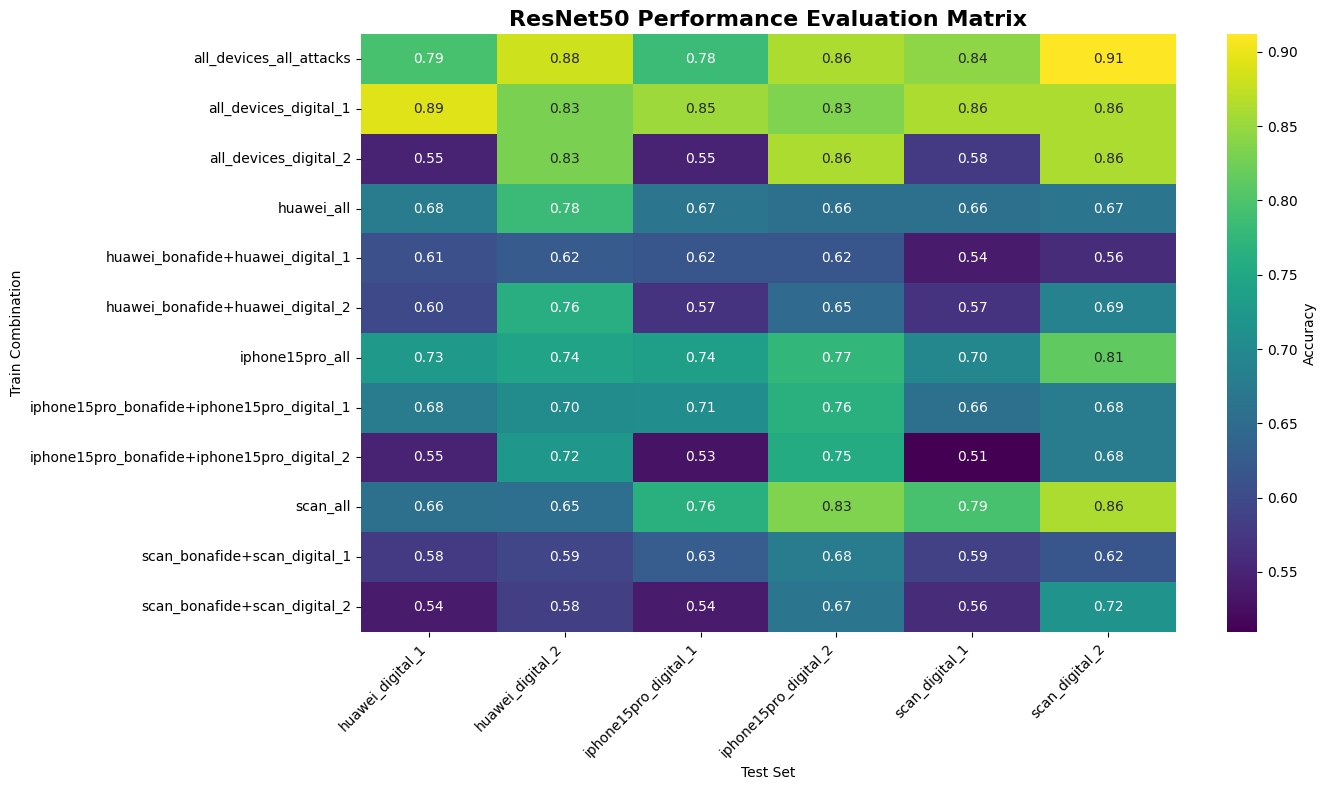

In [61]:
# Re-import required libraries due to code execution environment reset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the evaluation results
results_path = "resnet50_revised_results.csv"
results_df = pd.read_csv(results_path)

# Pivot the data to get a 12x6 accuracy matrix
accuracy_matrix = results_df.pivot(index="Train_Combo", columns="Test_Combo", values="Accuracy")

# Sort the rows and columns for consistent order
accuracy_matrix = accuracy_matrix.sort_index().sort_index(axis=1)

# Plot the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(accuracy_matrix, annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'Accuracy'})
plt.title("ResNet50 Performance Evaluation Matrix", fontsize=16, fontweight='bold')
plt.xlabel("Test Set")
plt.ylabel("Train Combination")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [62]:
plt.savefig("filename.png", dpi=300, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>

In [63]:
# Compute mean and std along rows (per model) and columns (per test case)
mean_per_model = accuracy_matrix.mean(axis=1)
mean_per_test = accuracy_matrix.mean(axis=0)
std_per_model = accuracy_matrix.std(axis=1)
std_per_test = accuracy_matrix.std(axis=0)



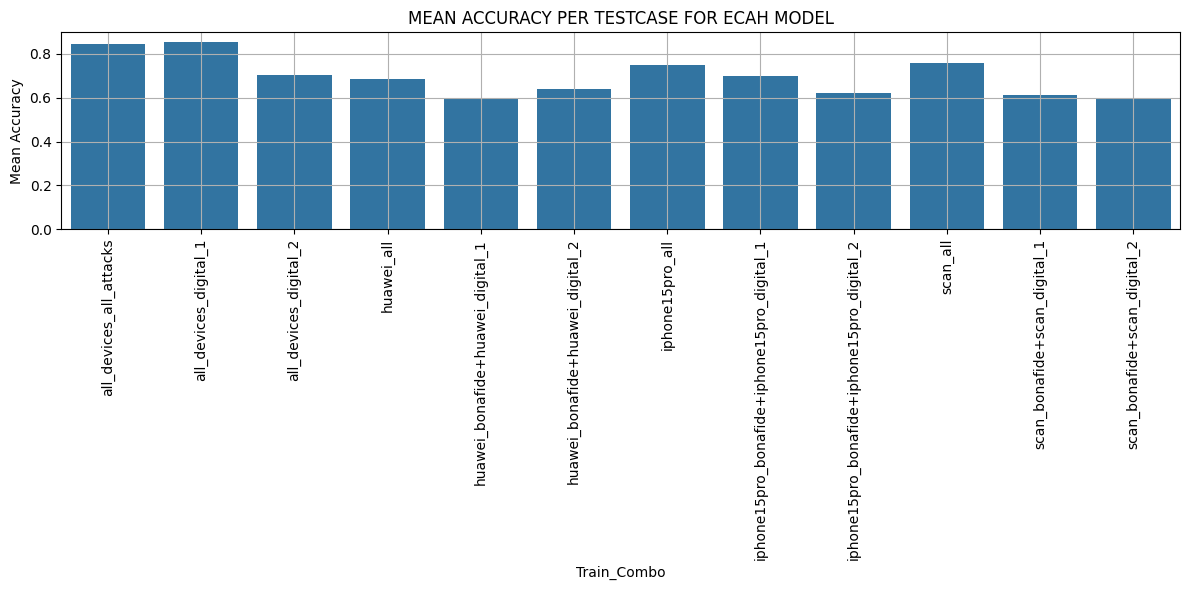

In [64]:
# Plot the mean accuracy per model across all test cases
plt.figure(figsize=(12, 6))
sns.barplot(x=mean_per_model.index, y=mean_per_model.values)
plt.xticks(rotation=90)
plt.ylabel("Mean Accuracy")
plt.title("MEAN ACCURACY PER TESTCASE FOR ECAH MODEL")
plt.tight_layout()
plt.grid(True)
plt.show()

/tmp/ipykernel_261241/1374115545.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_per_test.index, y=mean_per_test.values, palette="viridis")


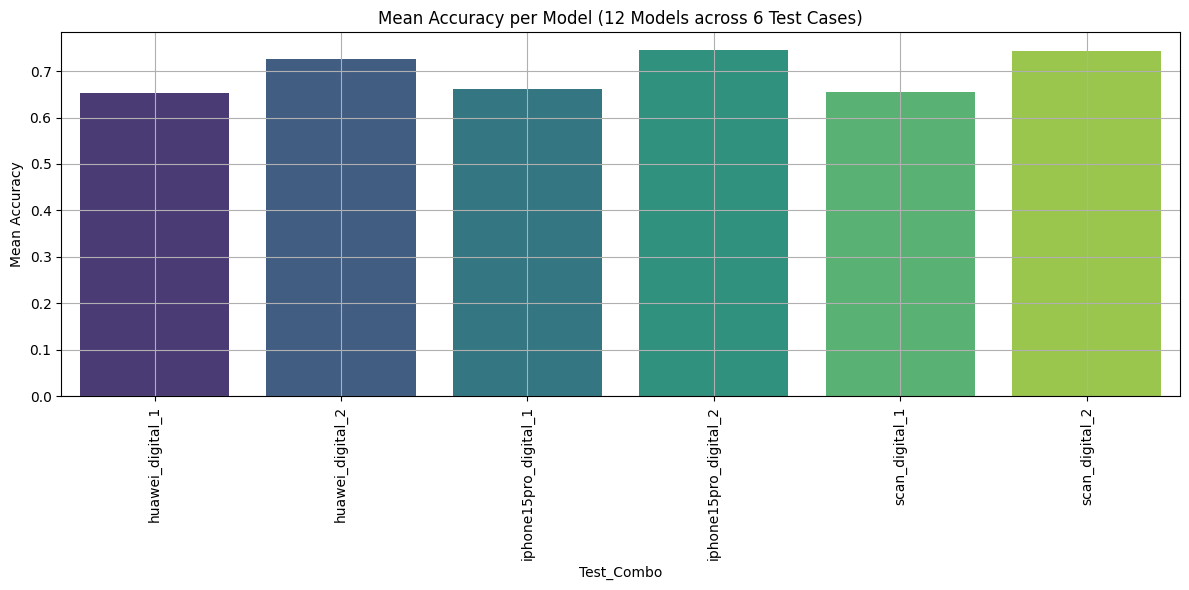

In [65]:
# Plot the mean accuracy per model across all test cases
plt.figure(figsize=(12, 6))
sns.barplot(x=mean_per_test.index, y=mean_per_test.values, palette="viridis")
plt.xticks(rotation=90)
plt.ylabel("Mean Accuracy")
plt.title("Mean Accuracy per Model (12 Models across 6 Test Cases)")
plt.tight_layout()
plt.grid(True)
plt.show()

/tmp/ipykernel_261241/2531943087.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=std_per_model.index, y=std_per_model.values, palette="viridis")


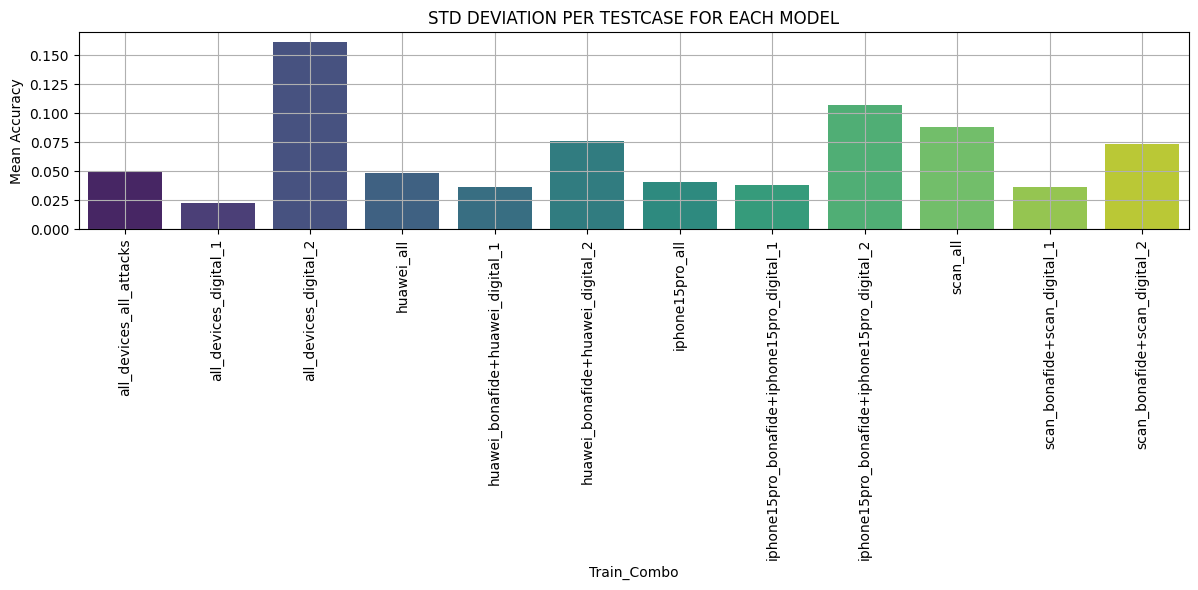

In [66]:
# Plot the mean accuracy per model across all test cases
plt.figure(figsize=(12, 6))
sns.barplot(x=std_per_model.index, y=std_per_model.values, palette="viridis")
plt.xticks(rotation=90)
plt.ylabel("Mean Accuracy")
plt.title("STD DEVIATION PER TESTCASE FOR EACH MODEL")
plt.tight_layout()
plt.grid(True)
plt.show()

/tmp/ipykernel_261241/3539867521.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=std_per_test.index, y=std_per_test.values, palette="Purples_d")


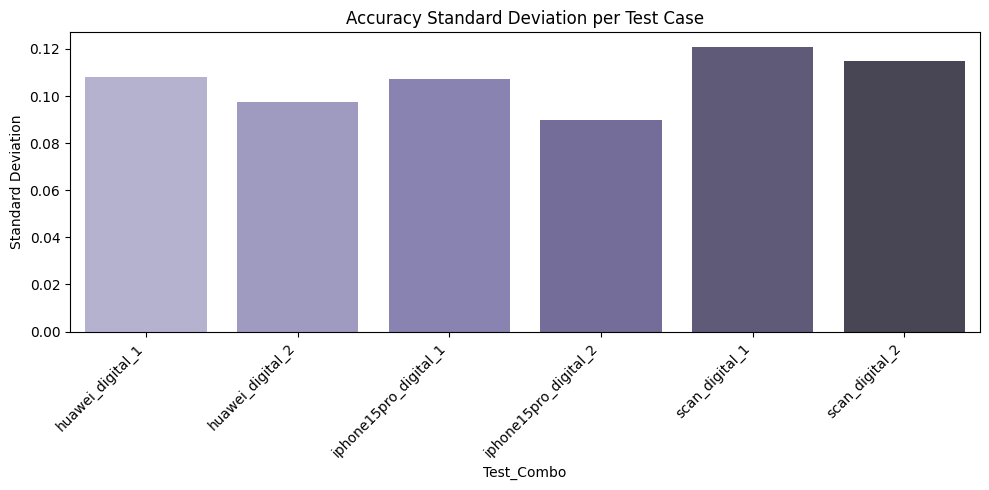

In [67]:
plt.figure(figsize=(10, 5))
sns.barplot(x=std_per_test.index, y=std_per_test.values, palette="Purples_d")
plt.ylabel("Standard Deviation")
plt.title("Accuracy Standard Deviation per Test Case")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [68]:
import os
import json
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn

# ------------------ ResNet50 Classifier Definition ------------------
class ResNet50Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        for name, param in backbone.named_parameters():
            if not ("layer3" in name or "layer4" in name or "fc" in name):
                param.requires_grad = False
        in_f = backbone.fc.in_features
        backbone.fc = nn.Sequential(
            nn.BatchNorm1d(in_f),
            nn.Dropout(0.4),
            nn.Linear(in_f, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),
            nn.Linear(256, 2),
        )
        self.net = backbone

    def forward(self, x):
        return self.net(x)

# ------------------ GradCAM Class ------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook()

    def hook(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax()
        self.model.zero_grad()
        output[0, class_idx].backward()
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = torch.relu((weights * self.activations).sum(dim=1)).squeeze().cpu().numpy()
        cam = cv2.resize(cam, (input_tensor.shape[3], input_tensor.shape[2]))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

# ------------------ Drawing Function ------------------
def draw_boxes_on_image(img, json_path):
    img_draw = img.copy()
    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            data = json.load(f)
        for shape in data.get("shapes", []):
            if "points" in shape:
                pts = shape["points"]
                x1, y1 = map(int, pts[0])
                x2, y2 = map(int, pts[1])
                cv2.rectangle(img_draw, (x1, y1), (x2, y2), (255, 0, 0), 2)
    return img_draw

# ------------------ Visualization Function ------------------
def show_comparison(bonafide_path, manipulated_path, json_path, model, cam_generator, transform, device):
    img_real = Image.open(bonafide_path).convert("RGB")
    img_att = Image.open(manipulated_path).convert("RGB")

    img_att_boxed = draw_boxes_on_image(np.array(img_att), json_path)

    input_tensor = transform(img_att).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(input_tensor)
        probs = torch.softmax(logits, dim=1)
        pred = probs.argmax(dim=1).item()
        score = probs[0, 1].item()

    cam_map = cam_generator.generate(input_tensor, class_idx=pred)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_map), cv2.COLORMAP_JET)

    img_att_boxed_np = cv2.cvtColor(img_att_boxed, cv2.COLOR_RGB2BGR)
    if img_att_boxed_np.shape[:2] != heatmap.shape[:2]:
        img_att_boxed_np = cv2.resize(img_att_boxed_np, (heatmap.shape[1], heatmap.shape[0]))

    overlay = cv2.addWeighted(img_att_boxed_np, 0.5, heatmap, 0.5, 0)

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(img_real)
    axs[0].set_title("Bonafide")
    axs[1].imshow(img_att_boxed)
    axs[1].set_title("Manipulated + Boxes")
    axs[2].imshow(cam_map, cmap="jet")
    axs[2].set_title("Grad-CAM Map")
    axs[3].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    axs[3].set_title("Overlay")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# ------------------ Runner Function ------------------
def run_visualization(df, model_path, json_root):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ResNet50Classifier()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device).eval()
    cam = GradCAM(model, model.net.layer4[-1])
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])

    manipulated_df = df[df['label'] == 'attack']
    for idx, row in manipulated_df.iterrows():
        attack_img_path = row['path']
        base_name = os.path.basename(attack_img_path)
        device_name = row['device']
        attack_type = row['attack_type']

        json_path = os.path.join(json_root, attack_type, device_name, base_name.replace(".jpg", ".json"))

        bonafide_row = df[(df['label'] == 'bonafide') & (df['device'] == device_name) & (df['rel_path'].str.contains(base_name.split("-")[0]))]

        if not bonafide_row.empty:
            bonafide_img_path = bonafide_row.iloc[0]['path']
            show_comparison(bonafide_img_path, attack_img_path, json_path, model, cam, transform, device)
        else:
            print(f"❌ Bonafide not found for {base_name}")


In [69]:
"""import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn

# Define model class
class ResNet50Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        in_f = backbone.fc.in_features
        backbone.fc = nn.Sequential(
            nn.BatchNorm1d(in_f),
            nn.Dropout(0.4),
            nn.Linear(in_f, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),
            nn.Linear(256, 2),
        )
        self.net = backbone

    def forward(self, x):
        return self.net(x)

# GradCAM++ implementation
class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook()

    def hook(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax()
        self.model.zero_grad()
        output[0, class_idx].backward(retain_graph=True)

        gradients = self.gradients
        activations = self.activations
        weights = torch.pow(gradients, 2)
        grads_power_3 = torch.pow(gradients, 3)
        norm = 2 * torch.pow(gradients, 2) + torch.sum(activations * grads_power_3, dim=(2, 3), keepdim=True)
        norm = torch.where(norm != 0.0, norm, torch.ones_like(norm))
        alpha = weights / norm
        weights = torch.sum(alpha * torch.relu(gradients), dim=(2, 3), keepdim=True)
        cam = torch.relu(torch.sum(weights * activations, dim=1)).squeeze().cpu().numpy()

        cam = cv2.resize(cam, (input_tensor.shape[3], input_tensor.shape[2]))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        cam = cv2.GaussianBlur(cam, (7, 7), 0)
        return cam

# Draw boxes from json for all regions
def draw_all_boxes(image: np.ndarray, json_path: str) -> np.ndarray:
    img_boxed = image.copy()
    if not os.path.exists(json_path):
        print(f"⚠️ JSON not found: {json_path}")
        return img_boxed
    with open(json_path, "r") as f:
        data = json.load(f)
    for region in data.get("regions", []):
        x = region["shape_attributes"]["x"]
        y = region["shape_attributes"]["y"]
        w = region["shape_attributes"]["width"]
        h = region["shape_attributes"]["height"]
        cv2.rectangle(img_boxed, (x, y), (x + w, y + h), (255, 0, 0), 4)
    return img_boxed

# Prepare transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

def load_and_preprocess(path, device):
    img = Image.open(path).convert("RGB")
    tensor = transform(img).unsqueeze(0).to(device)
    return img, tensor

def run_one_visual(df, model_path: str, device: str):
    os.makedirs("GradCAM++", exist_ok=True)
    model = ResNet50Classifier().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    cam = GradCAMPlusPlus(model, model.net.layer4[-1])

    for idx in range(len(df)):
        row = df.iloc[idx]
        if row['label'] == 'attack':
            manipulated_path = row['path']
            base_name = os.path.basename(manipulated_path).replace(".jpg", "")
            device_name = row['device']
            attack_type = row['attack_type']
            json_path = manipulated_path.replace(".jpg", ".json")

            bonafide_row = df[(df['label'] == 'bonafide') & (df['device'] == device_name) & (df['rel_path'].str.contains(base_name.split("-")[0]))]
            if bonafide_row.empty:
                continue
            bonafide_path = bonafide_row.iloc[0]['path']

            bonafide_img = np.array(Image.open(bonafide_path).convert("RGB"))
            manipulated_img = np.array(Image.open(manipulated_path).convert("RGB"))
            boxed_img = draw_all_boxes(manipulated_img, json_path)
            _, manipulated_tensor = load_and_preprocess(manipulated_path, device)
            cam_map = cam.generate(manipulated_tensor)
            heatmap = cv2.applyColorMap(np.uint8(255 * cam_map), cv2.COLORMAP_JET)
            overlay = cv2.addWeighted(cv2.resize(manipulated_img, (224, 224)), 0.5, heatmap, 0.5, 0)

            fig, axs = plt.subplots(1, 3, figsize=(24, 12))
            axs[0].imshow(bonafide_img); axs[0].set_title("Bonafide", fontsize=36)
            axs[1].imshow(boxed_img); axs[1].set_title("Manipulated + JSON Boxes", fontsize=36)
            axs[2].imshow(overlay[..., ::-1]); axs[2].set_title("Grad-CAM++ Overlay", fontsize=36)
            for ax in axs: ax.axis("off")
            plt.suptitle(f"📍 Device: {device_name}, Attack: {attack_type}, Image: {base_name}", fontsize=40)
            plt.tight_layout()

            save_path = os.path.join("GradCAM++", f"{device_name}_{attack_type}_{base_name}.png")
            plt.savefig(save_path, dpi=300)
            plt.show()
            break  # Remove this if you want to run over all

# Usage
print("CUDA available:", torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
run_one_visual(df, model_path="saved_models_resnet50/resnet50_all_devices_all_attacks.ptl", device=device)"""


'import os\nimport json\nimport torch\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport cv2\nfrom PIL import Image\nfrom torchvision import transforms\nfrom torchvision.models import resnet50, ResNet50_Weights\nimport torch.nn as nn\n\n# Define model class\nclass ResNet50Classifier(nn.Module):\n    def __init__(self):\n        super().__init__()\n        backbone = resnet50(weights=ResNet50_Weights.DEFAULT)\n        in_f = backbone.fc.in_features\n        backbone.fc = nn.Sequential(\n            nn.BatchNorm1d(in_f),\n            nn.Dropout(0.4),\n            nn.Linear(in_f, 256),\n            nn.ReLU(),\n            nn.BatchNorm1d(256),\n            nn.Dropout(0.4),\n            nn.Linear(256, 2),\n        )\n        self.net = backbone\n\n    def forward(self, x):\n        return self.net(x)\n\n# GradCAM++ implementation\nclass GradCAMPlusPlus:\n    def __init__(self, model, target_layer):\n        self.model = model.eval()\n        self.target_layer = target_layer\n     

In [70]:
"""import os
import json
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn

# ------------------ ResNet50 Classifier Definition ------------------
class ResNet50Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        for name, param in backbone.named_parameters():
            if not ("layer3" in name or "layer4" in name or "fc" in name):
                param.requires_grad = False
        in_f = backbone.fc.in_features
        backbone.fc = nn.Sequential(
            nn.BatchNorm1d(in_f),
            nn.Dropout(0.4),
            nn.Linear(in_f, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),
            nn.Linear(256, 2),
        )
        self.net = backbone

    def forward(self, x):
        return self.net(x)

# ------------------ GradCAM++ Class ------------------
class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook()

    def hook(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax()
        self.model.zero_grad()
        output[0, class_idx].backward(retain_graph=True)

        gradients = self.gradients
        activations = self.activations
        weights = torch.pow(gradients, 2)
        grads_power_3 = torch.pow(gradients, 3)
        norm = 2 * torch.pow(gradients, 2) + torch.sum(activations * grads_power_3, dim=(2, 3), keepdim=True)
        norm = torch.where(norm != 0.0, norm, torch.ones_like(norm))
        alpha = weights / norm
        weights = torch.sum(alpha * torch.relu(gradients), dim=(2, 3), keepdim=True)
        cam = torch.relu(torch.sum(weights * activations, dim=1)).squeeze().cpu().numpy()

        cam = cv2.resize(cam, (input_tensor.shape[3], input_tensor.shape[2]))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        cam = cv2.GaussianBlur(cam, (11, 11), 0)  # More spread
        return cam

# ------------------ Draw All Boxes ------------------
def draw_all_boxes(image_np, json_path):
    if not os.path.exists(json_path):
        return image_np
    with open(json_path, "r") as f:
        data = json.load(f)
    for region in data.get("regions", []):
        shape = region.get("shape_attributes", {})
        x, y, w, h = shape.get("x", 0), shape.get("y", 0), shape.get("width", 0), shape.get("height", 0)
        cv2.rectangle(image_np, (x, y), (x + w, y + h), (255, 0, 0), 5)
    return image_np

# ------------------ Visualization Function ------------------
def visualize_three_images(df, model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ResNet50Classifier()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device).eval()
    cam = GradCAMPlusPlus(model, model.net.layer4[-1])

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])

    manipulated_df = df[df['label'] == 'attack'].sample(n=200, random_state=42)

    for idx, row in manipulated_df.iterrows():
        attack_path = row['path']
        rel_path = row['rel_path']
        json_path = attack_path.replace(".jpg", ".json")
        device_name = row['device']
        attack_type = row['attack_type']
        filename = os.path.basename(attack_path)

        bonafide_row = df[(df['label'] == 'bonafide') & (df['device'] == device_name) & (df['rel_path'].str.contains(filename.split("-")[0]))]
        if bonafide_row.empty:
            continue

        bonafide_path = bonafide_row.iloc[0]['path']

        # Load Images
        bonafide_img = np.array(Image.open(bonafide_path).convert("RGB"))
        manipulated_img = np.array(Image.open(attack_path).convert("RGB"))
        boxed_img = draw_all_boxes(manipulated_img.copy(), json_path)

        input_tensor = transform(Image.fromarray(manipulated_img)).unsqueeze(0).to(device)
        cam_map = cam.generate(input_tensor)
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_map), cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(cv2.resize(manipulated_img, (224, 224)), 0.5, heatmap, 0.5, 0)

        # Plot
        fig, axs = plt.subplots(1, 3, figsize=(24, 10))

        axs[0].imshow(bonafide_img)
        axs[0].set_title(f"Bonafide\n{os.path.basename(bonafide_path)} ({device_name})", fontsize=24)

        axs[1].imshow(boxed_img)
        axs[1].set_title(f"Attack ({attack_type})\n{filename} ({device_name})", fontsize=24)

        axs[2].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        axs[2].set_title(f"GradCAM++ Overlay\n{filename} ({device_name})", fontsize=24)

        for ax in axs:
            ax.axis("off")

        plt.tight_layout()
        plt.show()

# Example usage:
visualize_three_images(df, model_path="saved_models_resnet50/resnet50_all_devices_all_attacks.ptl")"""


'import os\nimport json\nimport cv2\nimport torch\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom PIL import Image\nfrom torchvision import transforms\nfrom torchvision.models import resnet50, ResNet50_Weights\nimport torch.nn as nn\n\n# ------------------ ResNet50 Classifier Definition ------------------\nclass ResNet50Classifier(nn.Module):\n    def __init__(self):\n        super().__init__()\n        backbone = resnet50(weights=ResNet50_Weights.DEFAULT)\n        for name, param in backbone.named_parameters():\n            if not ("layer3" in name or "layer4" in name or "fc" in name):\n                param.requires_grad = False\n        in_f = backbone.fc.in_features\n        backbone.fc = nn.Sequential(\n            nn.BatchNorm1d(in_f),\n            nn.Dropout(0.4),\n            nn.Linear(in_f, 256),\n            nn.ReLU(),\n            nn.BatchNorm1d(256),\n            nn.Dropout(0.4),\n            nn.Linear(256, 2),\n        )\n        self.net = backbone\n\n    def f

In [80]:
import os
import json
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn

# ------------------ Model Definition ------------------
class ResNet50Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        for name, param in backbone.named_parameters():
            if not ("layer3" in name or "layer4" in name or "fc" in name):
                param.requires_grad = False
        in_f = backbone.fc.in_features
        backbone.fc = nn.Sequential(
            nn.BatchNorm1d(in_f),
            nn.Dropout(0.4),
            nn.Linear(in_f, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),
            nn.Linear(256, 2),
        )
        self.net = backbone

    def forward(self, x):
        return self.net(x)

# ------------------ GradCAM Class ------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook()

    def hook(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax()
        self.model.zero_grad()
        output[0, class_idx].backward()
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = torch.relu((weights * self.activations).sum(dim=1)).squeeze().cpu().numpy()
        cam = cv2.resize(cam, (input_tensor.shape[3], input_tensor.shape[2]))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

# ------------------ Draw Boxes ------------------
def draw_boxes(img, json_path):
    if not os.path.exists(json_path):
        return img
    with open(json_path, 'r') as f:
        data = json.load(f)
    for region in data.get("regions", []):
        shape = region.get("shape_attributes", {})
        x, y, w, h = shape.get("x", 0), shape.get("y", 0), shape.get("width", 0), shape.get("height", 0)
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 4)
    return img

# ------------------ Main Visualizer ------------------
def visualize_classified_misclassified(df, model_path, output_dir, num_samples=20):
    os.makedirs(output_dir, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ResNet50Classifier()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device).eval()
    cam = GradCAM(model, model.net.layer4[-1])

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])

    df_sample = df.sample(n=num_samples, random_state=42)

    for i, row in df_sample.iterrows():
        path = row['path']
        rel_path = row['rel_path']
        true_label = row['label']
        device_name = row['device']
        attack_type = row.get('attack_type', 'N/A')
        image = Image.open(path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model(input_tensor)
            probs = torch.softmax(logits, dim=1)
            pred_score = probs[0, 1].item()
            pred_label = 'attack' if pred_score >= 0.5 else 'bonafide'

        predicted_correctly = (pred_label == true_label)
        category = "classified" if predicted_correctly else "misclassified"

        cam_map = cam.generate(input_tensor)
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_map), cv2.COLORMAP_JET)
        img_np = np.array(image)
        resized_img = cv2.resize(img_np, (224, 224))
        overlay = cv2.addWeighted(resized_img, 0.5, heatmap, 0.5, 0)

        boxed_img = draw_boxes(resized_img.copy(), path.replace(".jpg", ".json"))

        fig, axs = plt.subplots(1, 3, figsize=(24, 10))
        axs[0].imshow(img_np)
        axs[0].set_title(f"Original ({true_label})\n{os.path.basename(path)} [{device_name}]", fontsize=28)
        axs[1].imshow(boxed_img)
        axs[1].set_title(f"With Annotations ({attack_type})", fontsize=28)
        axs[2].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        axs[2].set_title(f"GradCAM++ ({pred_label}, Score: {pred_score:.2f})", fontsize=28)

        for ax in axs:
            ax.axis("off")

        plt.tight_layout()
        save_name = f"{category}_{i}_{os.path.basename(path).replace('.jpg', '')}.png"
        plt.savefig(os.path.join(output_dir, save_name))
        plt.close()

# Example usage:
visualize_classified_misclassified(df, model_path="saved_models_resnet50/resnet50_all_devices_all_attacks.ptl", output_dir="GRADCAM_RESNET50_CLASSIFIED_MISCLASSIFIED")


/home/dse/jupyter_env/lib/python3.12/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [72]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [73]:
def parse_combo(name):
    if name.endswith("_all"):
        device = name.replace("_all", "")
        return {"devices": [device], "attacks": ["digital_1", "digital_2"]}
    elif name.startswith("all_devices"):
        if name.endswith("all_attacks"):
            return {"devices": ["huawei", "iphone15pro", "scan"], "attacks": ["digital_1", "digital_2"]}
        elif name.endswith("digital_1"):
            return {"devices": ["huawei", "iphone15pro", "scan"], "attacks": ["digital_1"]}
        elif name.endswith("digital_2"):
            return {"devices": ["huawei", "iphone15pro", "scan"], "attacks": ["digital_2"]}
    else:
        parts = name.split("+")
        cfg = {"bonafide": {}, "attack": {}}
        for part in parts:
            device, rest = part.split("_", 1)
            if rest == "bonafide":
                cfg["bonafide"] = {"device": device}
            else:
                cfg["attack"] = {"device": device, "attack_type": rest}
        return cfg

class FantasyIDDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, split='train', image_size=(224, 224)):
        self.df = dataframe[dataframe['split'] == split].reset_index(drop=True)
        self.label_map = {'bonafide': 0, 'attack': 1}
        self.split = split
        self.transform = transforms.Compose([
            transforms.Resize(image_size, interpolation=InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.ColorJitter(0.3, 0.3, 0.3)], p=0.7),
            AutoAugment(policy=AutoAugmentPolicy.IMAGENET),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ]) if split == 'train' else transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        label = self.label_map[row['label']]
        image = Image.open(row['path']).convert("RGB")
        metadata = {
        'device': row['device'],
        'attack_type': row.get('attack_type', None)
        }

        return self.transform(image), label , metadata

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing

    def forward(self, x, target):
        logprobs = torch.nn.functional.log_softmax(x, dim=-1)
        nll = -logprobs.gather(dim=-1, index=target.unsqueeze(1)).squeeze(1)
        smooth = -logprobs.mean(dim=-1)
        return (self.confidence * nll + self.smoothing * smooth).mean()

class SwinClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        from torchvision.models import swin_t, Swin_T_Weights
        self.backbone = swin_t(weights=Swin_T_Weights.DEFAULT)
        in_features = self.backbone.head.in_features
        self.backbone.head = nn.Linear(in_features, 2)

    def forward(self, x):
        return self.backbone(x)


In [74]:

"""import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
from tqdm import tqdm
from PIL import Image
from timm.data.mixup import Mixup

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
NUM_EPOCHS = 10
BATCH_SIZE = 32
SAVE_DIR = "saved_models_swin"
os.makedirs(SAVE_DIR, exist_ok=True)

# Define 12 training combinations
combo_names = [
    "huawei_bonafide+huawei_digital_1",
    "huawei_bonafide+huawei_digital_2",
    "huawei_all",
    "iphone15pro_bonafide+iphone15pro_digital_1",
    "iphone15pro_bonafide+iphone15pro_digital_2",
    "iphone15pro_all",
    "scan_bonafide+scan_digital_1",
    "scan_bonafide+scan_digital_2",
    "scan_all",
    "all_devices_digital_1",
    "all_devices_digital_2",
    "all_devices_all_attacks"
]


# --- Main Training Loop ---
for name in combo_names:
    cfg = parse_combo(name)

    print(f"\n📦 Training on: {name}")

    if "bonafide" in cfg and "attack" in cfg:
        attack_mask = (
            (df.split == "train") &
            (df.device == cfg["attack"]["device"]) &
            (df.label == "attack") &
            (df.attack_type == cfg["attack"]["attack_type"])
        )
        bona_mask = (
            (df.split == "train") &
            (df.device == cfg["bonafide"]["device"]) &
            (df.label == "bonafide")
        )
    else:
        attack_mask = (
            (df.split == "train") &
            (df.device.isin(cfg["devices"])) &
            (df.attack_type.isin(cfg["attacks"])) &
            (df.label == "attack")
        )
        bona_mask = (
            (df.split == "train") &
            (df.device.isin(cfg["devices"])) &
            (df.label == "bonafide")
        )

    train_df = df[attack_mask | bona_mask].reset_index(drop=True)

    if train_df.label.nunique() < 2:
        print("❌ Not enough classes, skipping.")
        continue

    train_df["label_encoded"] = train_df["label"].map({'bonafide': 0, 'attack': 1})
    class_weights = train_df["label_encoded"].value_counts().to_dict()
    total = sum(class_weights.values())
    weights = {k: total / v for k, v in class_weights.items()}
    sampler_weights = train_df["label_encoded"].map(weights).values
    sampler = WeightedRandomSampler(torch.tensor(sampler_weights, dtype=torch.float), len(sampler_weights), replacement=True)

    train_dataset = FantasyIDDataset(train_df, split='train')
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)

    model = SwinClassifier().to(DEVICE)
    criterion = LabelSmoothingCrossEntropy(smoothing=0.1)

    head_params = list(model.backbone.head.parameters())
    head_param_ids = {id(p) for p in head_params}
    all_backbone_params = [p for p in model.backbone.parameters() if id(p) not in head_param_ids]
    cutoff = int(len(all_backbone_params) * 0.6)
    for p in all_backbone_params[:cutoff]: p.requires_grad = False
    for p in all_backbone_params[cutoff:]: p.requires_grad = True
    for p in head_params: p.requires_grad = True

    optimizer = optim.AdamW([
        {"params": all_backbone_params[cutoff:], "lr": 1e-4},
        {"params": head_params, "lr": 1e-4}
    ], weight_decay=1e-4)

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

    best_loss = float('inf')
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for batch in tqdm(train_loader, desc=f"[{name}] Epoch {epoch+1}"):
            inputs, labels = batch
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        print(f"Epoch {epoch+1} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")
        scheduler.step()

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), os.path.join(SAVE_DIR, f"swin_{name}.ptl"))
            print(f"✅ Saved best model for {name}")

print("🎯 All training complete.")"""


'import os\nimport torch\nimport torch.nn as nn\nimport torch.optim as optim\nfrom torch.utils.data import DataLoader, WeightedRandomSampler\nfrom torchvision import transforms\nfrom torchvision.transforms import InterpolationMode\nfrom torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy\nfrom tqdm import tqdm\nfrom PIL import Image\nfrom timm.data.mixup import Mixup\n\n# Device\nDEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\n# Hyperparameters\nNUM_EPOCHS = 10\nBATCH_SIZE = 32\nSAVE_DIR = "saved_models_swin"\nos.makedirs(SAVE_DIR, exist_ok=True)\n\n# Define 12 training combinations\ncombo_names = [\n    "huawei_bonafide+huawei_digital_1",\n    "huawei_bonafide+huawei_digital_2",\n    "huawei_all",\n    "iphone15pro_bonafide+iphone15pro_digital_1",\n    "iphone15pro_bonafide+iphone15pro_digital_2",\n    "iphone15pro_all",\n    "scan_bonafide+scan_digital_1",\n    "scan_bonafide+scan_digital_2",\n    "scan_all",\n    "all_devices_digital_1",

In [75]:
"""import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from torch.utils.data import DataLoader
from torchvision.models import swin_t, Swin_T_Weights
import torch.nn as nn

# Save folders
os.makedirs("evaluation_results_swin", exist_ok=True)
os.makedirs("evaluation_results/plots", exist_ok=True)


# Swin Classifier
class SwinClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = swin_t(weights=Swin_T_Weights.DEFAULT)
        in_features = self.backbone.head.in_features
        self.backbone.head = nn.Linear(in_features, 2)

    def forward(self, x):
        return self.backbone(x)


# Evaluation helper
def evaluate_model(model, dataloader, device):
    model.eval()
    y_true, y_pred, y_score = [], [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            probs = torch.softmax(out, dim=1)
            pred = probs.argmax(dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
            y_score.extend(probs[:, 1].cpu().numpy())
    return y_true, y_pred, y_score


# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_cases = [
    ("huawei", "digital_1"), ("huawei", "digital_2"),
    ("scan", "digital_1"), ("scan", "digital_2"),
    ("iphone15pro", "digital_1"), ("iphone15pro", "digital_2"),
]

test_labels = [f"{d}_{a}" for d, a in test_cases]
model_names = sorted([f.replace(".ptl", "") for f in os.listdir("saved_models_swin") if f.endswith(".ptl")])

# Initialize results storage
accuracy_matrix = pd.DataFrame(index=model_names, columns=test_labels)
auc_matrix = pd.DataFrame(index=model_names, columns=test_labels)

# Evaluate all models
for model_file in sorted(os.listdir("saved_models_swin")):
    if not model_file.endswith(".ptl"):
        continue

    model = SwinClassifier().to(device)
    model.load_state_dict(torch.load(os.path.join("saved_models_swin", model_file), map_location=device))

    for device_name, attack_type in test_cases:
        test_df = df[
            (df['split'] == 'test') &
            (df['device'] == device_name) &
            ((df['label'] == 'bonafide') | ((df['label'] == 'attack') & (df['attack_type'] == attack_type)))
        ].reset_index(drop=True)

        if test_df.empty:
            print(f"⚠️ No test samples for {model_file} | {device_name} {attack_type}")
            continue

        test_loader = DataLoader(FantasyIDDataset(test_df, split='test'), batch_size=32, shuffle=False)
        y_true, y_pred, y_score = evaluate_model(model, test_loader, device)

        if len(set(y_true)) < 2:
            print(f"⚠️ Only one class in true labels — skipping AUC for {model_file} | {device_name} {attack_type}")
            continue

        acc = np.mean(np.array(y_true) == np.array(y_pred))
        auc = roc_auc_score(y_true, y_score)

        model_name = model_file.replace('.ptl', '')
        test_label = f"{device_name}_{attack_type}"
        accuracy_matrix.loc[model_name, test_label] = acc
        auc_matrix.loc[model_name, test_label] = auc

        tag = f"{model_name}_{test_label}"
        print(f"✅ {tag} → Acc={acc:.3f}, AUC={auc:.3f}")

# Save matrices to CSV
accuracy_matrix.to_csv("evaluation_results_swin/swin_12x6_accuracy_matrix.csv")
auc_matrix.to_csv("evaluation_results_swin/swin_12x6_auc_matrix.csv")

# Plot heatmap for accuracy
plt.figure(figsize=(12, 6))
sns.heatmap(accuracy_matrix.astype(float), annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Swin Model Accuracy on 6 Test Cases")
plt.xlabel("Test Set")
plt.ylabel("Trained Model")
plt.tight_layout()
plt.savefig("evaluation_results/plots/swin_12x6_accuracy_matrix.png")
plt.show()

# Plot heatmap for AUC
plt.figure(figsize=(12, 6))
sns.heatmap(auc_matrix.astype(float), annot=True, fmt=".3f", cmap="Oranges")
plt.title("Swin Model AUC on 6 Test Cases")
plt.xlabel("Test Set")
plt.ylabel("Trained Model")
plt.tight_layout()
plt.savefig("evaluation_results/plots/swin_12x6_auc_matrix.png")
plt.show()

print("\n✅ Evaluation matrices and plots saved.")
"""


'import os\nimport torch\nimport numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nfrom sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve\nfrom torch.utils.data import DataLoader\nfrom torchvision.models import swin_t, Swin_T_Weights\nimport torch.nn as nn\n\n# Save folders\nos.makedirs("evaluation_results_swin", exist_ok=True)\nos.makedirs("evaluation_results/plots", exist_ok=True)\n\n\n# Swin Classifier\nclass SwinClassifier(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.backbone = swin_t(weights=Swin_T_Weights.DEFAULT)\n        in_features = self.backbone.head.in_features\n        self.backbone.head = nn.Linear(in_features, 2)\n\n    def forward(self, x):\n        return self.backbone(x)\n\n\n# Evaluation helper\ndef evaluate_model(model, dataloader, device):\n    model.eval()\n    y_true, y_pred, y_score = [], [], []\n    with torch.no_grad():\n        for x, y in dataloader:\n            x = x.

In [76]:
assert not set(train_df['path']).intersection(set(test_df['path']))


In [77]:
df.groupby(['split', 'device', 'attack_type', 'label']).size()


split  device       attack_type  label 
test   huawei       digital_1    attack     51
                    digital_2    attack     50
       iphone15pro  digital_1    attack     51
                    digital_2    attack     51
       scan         digital_1    attack     51
                    digital_2    attack     51
train  huawei       digital_1    attack    211
                    digital_2    attack    211
       iphone15pro  digital_1    attack    211
                    digital_2    attack    211
       scan         digital_1    attack    211
                    digital_2    attack    211
dtype: int64

In [78]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
from torchvision.models import swin_t, Swin_T_Weights

# ─────────────────────────────────────────────────────────────────────────────
# Swin Classifier
class SwinClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = swin_t(weights=Swin_T_Weights.DEFAULT)
        in_features = self.backbone.head.in_features
        self.backbone.head = nn.Linear(in_features, 2)

    def forward(self, x):
        return self.backbone(x)

# ─────────────────────────────────────────────────────────────────────────────
# Grad-CAM utility
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook()

    def hook(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax()
        self.model.zero_grad()
        output[0, class_idx].backward()
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1).squeeze().cpu().numpy()
        cam = cv2.resize(cam, (input_tensor.shape[3], input_tensor.shape[2]))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

# ─────────────────────────────────────────────────────────────────────────────
# Plot helper
def plot_gradcam(image_tensor, cam_map, title=None, save_path=None):
    img_np = image_tensor.cpu()
    img_np = img_np.permute(1, 2, 0).clamp(0, 1).numpy()
    img_uint8 = np.uint8(img_np * 255)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam_map), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_uint8, 0.5, heatmap, 0.5, 0)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img_uint8)
    axs[1].imshow(cam_map, cmap="jet")
    axs[2].imshow(overlay[..., ::-1])
    for ax in axs: ax.axis("off")
    axs[0].set_title(title or "")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.close()

# ─────────────────────────────────────────────────────────────────────────────
# Grad-CAM Analysis Loop

def gradcam_analysis_swin(models_dir, df, device):
    test_combos = [
        ("huawei", "digital_1"), ("huawei", "digital_2"),
        ("scan", "digital_1"), ("scan", "digital_2"),
        ("iphone15pro", "digital_1"), ("iphone15pro", "digital_2"),
    ]

    os.makedirs("swin_gradcam", exist_ok=True)
    model_files = [f for f in os.listdir(models_dir) if f.endswith(".ptl")]

    weights = Swin_T_Weights.DEFAULT
    transform = weights.transforms()

    for model_file in model_files:
        print(f"\n🔍 Analyzing model: {model_file}")
        model = SwinClassifier()
        model.load_state_dict(torch.load(os.path.join(models_dir, model_file), map_location=device))
        model.to(device).eval()

        cam = GradCAM(model, model.backbone.features[5][-1])  # Stage 3, last block

        test_ds = FantasyIDDataset(df, split="test")

        for device_name, attack_type in test_combos:
            correct_idx, wrong_idx = None, None

            for i in range(len(test_ds)):
                image, label, meta = test_ds[i]
                if meta['device'] != device_name:
                    continue
                if label == 1 and meta.get("attack_type") != attack_type:
                    continue

                input_tensor = image.unsqueeze(0).to(device)
                with torch.no_grad():
                    logits = model(input_tensor)
                    probs = torch.softmax(logits, dim=1)
                    pred = probs.argmax(dim=1).item()

                if pred == label and correct_idx is None:
                    correct_idx = i
                elif pred != label and wrong_idx is None:
                    wrong_idx = i

                if correct_idx is not None and wrong_idx is not None:
                    break

            for idx, tag in zip([correct_idx, wrong_idx], ["correct", "wrong"]):
                if idx is None:
                    continue
                image, label, meta = test_ds[idx]
                input_tensor = image.unsqueeze(0).to(device)
                with torch.no_grad():
                    logits = model(input_tensor)
                    probs = torch.softmax(logits, dim=1)
                    pred = probs.argmax(dim=1).item()
                    score = probs[0, 1].item()

                if score < 0.6:
                    continue

                cam_map = cam.generate(input_tensor, class_idx=pred)
                save_name = f"{model_file.replace('.ptl','')}_{device_name}_{attack_type}_{tag}.png"
                save_path = os.path.join("swin_gradcam", save_name)
                plot_title = f"{tag.capitalize()} | {meta['device']} {meta.get('attack_type', '')}\nTrue: {label}, Pred: {pred}, Score: {score:.2f}"
                plot_gradcam(image, cam_map, plot_title, save_path=save_path)

    print("\n✅ Grad-CAM analysis complete. Results saved in swin_gradcam")




In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gradcam_analysis_swin("saved_models_swin", df, device)


🔍 Analyzing model: swin_all_devices_all_attacks.ptl

🔍 Analyzing model: swin_scan_bonafide+scan_digital_2.ptl

🔍 Analyzing model: swin_huawei_all.ptl

🔍 Analyzing model: swin_scan_all.ptl

🔍 Analyzing model: swin_scan_bonafide+scan_digital_1.ptl

🔍 Analyzing model: swin_huawei_bonafide+huawei_digital_1.ptl

🔍 Analyzing model: swin_iphone15pro_all.ptl

🔍 Analyzing model: swin_iphone15pro_bonafide+iphone15pro_digital_2.ptl

🔍 Analyzing model: swin_all_devices_digital_1.ptl

🔍 Analyzing model: swin_iphone15pro_bonafide+iphone15pro_digital_1.ptl

🔍 Analyzing model: swin_huawei_bonafide+huawei_digital_2.ptl

🔍 Analyzing model: swin_all_devices_digital_2.ptl

✅ Grad-CAM analysis complete. Results saved in swin_gradcam


In [11]:
import os
from PIL import Image, ImageEnhance, ImageFilter

def enhance_image(input_path, output_name="enhanced_output.png"):
    """
    Enhance the text clarity of an image without increasing saturation or cropping:
    - Preserve original size and aspect ratio
    - Apply edge-preserving sharpening only
    - Avoid any unnecessary brightness or color enhancement
    - Save as PNG in the saved_images directory

    Args:
    - input_path (str): Path to input image
    - output_name (str): Name for the saved image (PNG format)
    """
    # Create directory if it doesn't exist
    output_dir = "saved_images"
    os.makedirs(output_dir, exist_ok=True)

    # Load the image without altering color space
    img = Image.open(input_path).convert("RGB")
    img.load()

    # Copy image to a full white canvas to avoid accidental crop
    full_canvas = Image.new("RGB", img.size, (255, 255, 255))
    full_canvas.paste(img, (0, 0))

    # Apply mild sharpening to improve text clarity only
    sharpened_img = full_canvas.filter(ImageFilter.UnsharpMask(radius=1, percent=200, threshold=1))

    # Save image in PNG format with original dimensions
    output_path = os.path.join(output_dir, output_name)
    sharpened_img.save(output_path, format="PNG")

    print(f"Image saved at: {output_path}")
    return output_path

# Example usage:
enhance_image("/home/dse/Pictures/Screenshots/resnet18.png", "resnet18_matrix.png")






Image saved at: saved_images/resnet18_matrix.png


'saved_images/resnet18_matrix.png'